In [84]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
import re
from dataset import COCOPanopticDataset, COCODataLoader, COCOPanopticExample
from copy import copy, deepcopy
import json
from PIL import Image
import pickle as pkl

from gradio_pww import unpack_layers
import psd_tools
import numpy as np
import torch
from pathlib import Path
from functools import partial
import itertools
import random

In [86]:
def segmap_from_layers(layers, globalprompt):
    ret = None
    retdict = {}
    for i, layer in enumerate(layers):
        randomcolor = torch.randint(0, 256, (3,))     # RGB
        code = randomcolor[0].item() + randomcolor[1].item() * 256 + randomcolor[2].item() * (256**2)
        if f":{i}}}" in globalprompt:
            globalprompt = re.sub(f"\:{i}\\}}", f":{code}}}", globalprompt)
        mask = layer[(512,512)]
        maskcolor = mask.unsqueeze(-1).repeat(1, 1, 3) * randomcolor[None, None, :]
        if ret is None:
            ret = torch.zeros_like(maskcolor)
        ret = torch.where(mask.unsqueeze(-1) > 0.5, maskcolor, ret)
        retdict[code] = {"caption": layer["pos"]}
        print(layer["pos"])
        maskimg = mask[:,:, None].repeat(1,1,3).long().cpu().numpy() * 255
        print(maskimg.shape, maskimg.max())
        display(Image.fromarray(maskimg.astype(np.uint8)))
        
    ret = (ret).to(torch.long).cpu().numpy()
    
    return ret, retdict, globalprompt

def psd_to_cocopanoptic(fp):
    layers = psd_tools.PSDImage.open(fp)
    spec = unpack_layers(layers)
    segmap, prompts, globalprompt = segmap_from_layers(spec["layers"], spec["global"]["pos"])
    img = Image.fromarray(segmap.astype(np.uint8))
    ret = COCOPanopticExample(
        id=-1,
        img=img,
        captions=[globalprompt],
        seg_img=img,
        seg_info=prompts,
        cropsize=512
    )
    return ret

def display_example(x):
    display(x.load_seg_image())
    print(x.captions)
    print(repr(x.seg_info))


In [87]:
# examples with three circular shapes
threecirclesexamples = []

a highly detailed photorealistic image of a wooden table
(512, 512, 3) 255


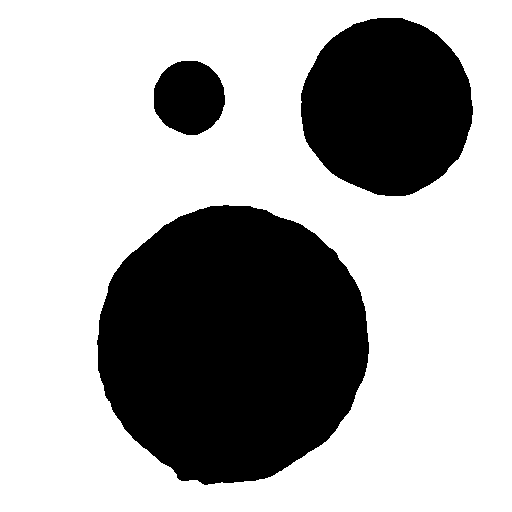

a highly detailed photorealistic image of a red tennis ball
(512, 512, 3) 255


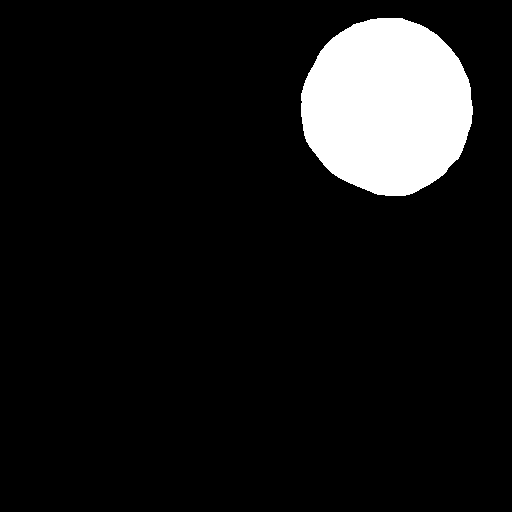

a highly detailed photorealistic image of a blue crystal ball
(512, 512, 3) 255


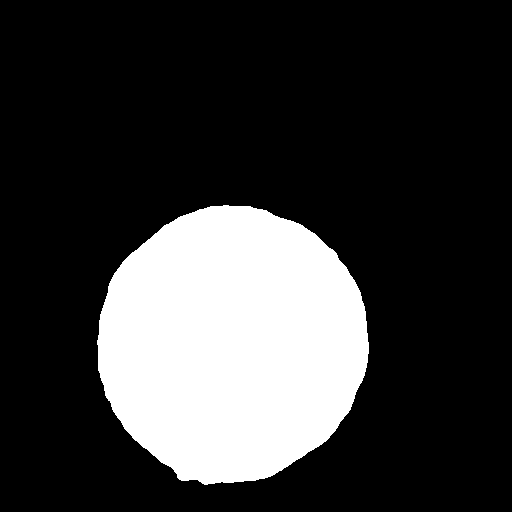

a highly detailed photorealistic image of a gold coin
(512, 512, 3) 255


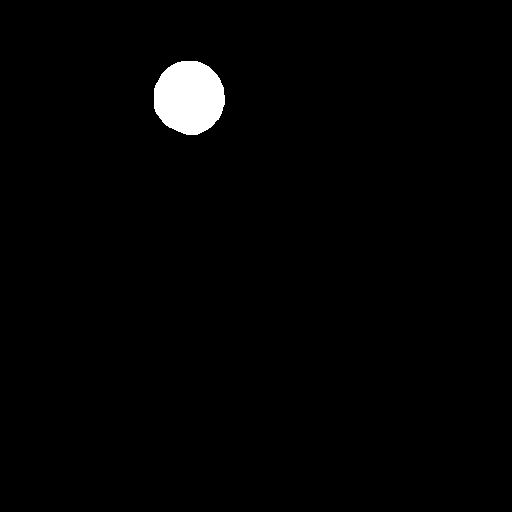

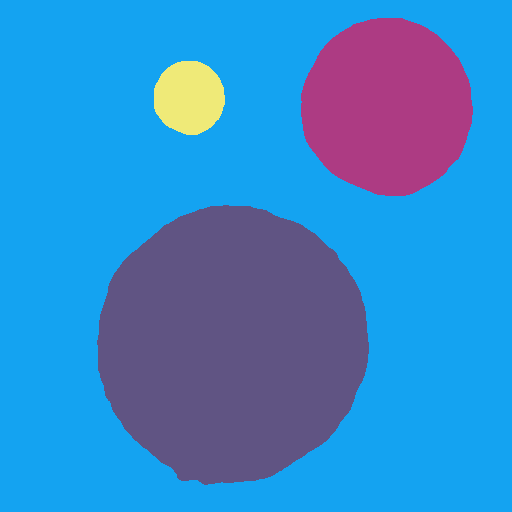

['a highly detailed photorealistic image of {a gold coin:7924463}, {a blue crystal ball:8606816} and {a red tennis ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red tennis ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a blue crystal ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a gold coin'}}


In [88]:
fp = 'evaldata/threeballs.psd'

torch.manual_seed(44)
example = psd_to_cocopanoptic(fp)
display_example(example)

In [89]:
# create prototype from example

def _replace_func(matchobj, key="", repl=""):
    # matchobj: "{<OBJA>:1234}", key="<OBJA>", repl="a sunny {day}", output: "a sunny {day:1234}"
    m = re.match("^[^\{]+\{([^\}]+)\}.*$", repl)
    src = matchobj.group(0)
    if m:
        corerepl = m.group(1)     # "day"
        src = src.replace(key, corerepl)    # "{day:1234}"
        ret = repl.replace("{" + corerepl + "}", src)
    else:
        ret = src.replace(key, repl)
    return ret
    

def replace_in_captions(x, repls):
    newcaptions = []
    for caption in x.captions:
        for k, v in repls.items():
            caption = re.sub(r"{{{k}:\d+}}".format(k=k), partial(_replace_func, key=k, repl=v), caption)
            caption = caption.replace(k, v)
        newcaptions.append(caption)

    new_seg_info = {}
    for regioncode, regioninfo in x.seg_info.items():
        caption = regioninfo["caption"]
        for k, v in repls.items():
            v = re.sub(r"\{([^\}]+)\}", r"\1", v)
            caption = caption.replace(k, v)
        new_seg_info[regioncode] = {"caption": caption}

    ret = deepcopy(x)
    ret.captions = newcaptions
    ret.seg_info = new_seg_info
    return ret

In [90]:
k = "<OBJ>"
caption = "it is {<OBJ>:123} ."
v = "a sunny {day} today"
re.sub(r"{{{k}:\d+}}".format(k=k), partial(_replace_func, key=k, repl=v), caption)

'it is a sunny {day:123} today .'

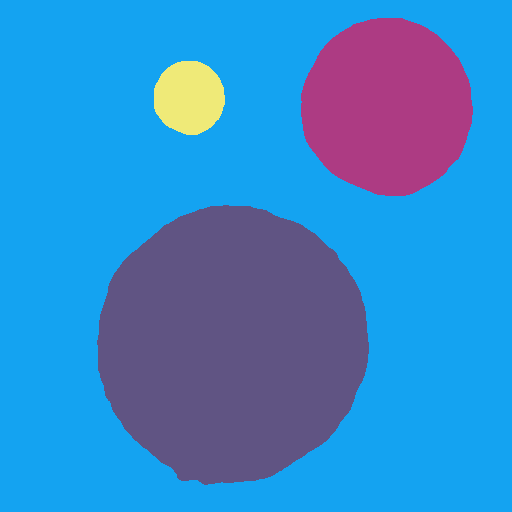

['a highly detailed photorealistic image of {<OBJ_A>:7924463}, {<OBJ_B>:8606816} and {<OBJ_C>:8600493} on {<OBJ_D>:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of <OBJ_D>'}, 8600493: {'caption': 'a highly detailed photorealistic image of <OBJ_C>'}, 8606816: {'caption': 'a highly detailed photorealistic image of <OBJ_B>'}, 7924463: {'caption': 'a highly detailed photorealistic image of <OBJ_A>'}}


In [91]:
repls = {
    "a gold coin": "<OBJ_A>",
    "a blue crystal ball": "<OBJ_B>",
    "a red tennis ball": "<OBJ_C>",
    "a wooden table": "<OBJ_D>"
}
prototype = replace_in_captions(example, repls)
display_example(prototype)

In [92]:
import random
import itertools

random.seed(42)

In [95]:
# setting one: balls
objects = ["a {color} crystal ball", "a {color} tennis ball", "a {color} ping pong ball"]
object_colors = ["red", "blue", "yellow"]
backgrounds = ["a wooden table", "grass"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        # print(objperm)
        for colorperm in itertools.permutations(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                spec[posname] = obj.format(color=color)
            specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
    
    
# iterate through possible combinations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    specset = set()
    for objperm in itertools.combinations_with_replacement(objects, 3):
        # print(objperm)
        _spec = deepcopy(spec)
        for colorperm in itertools.combinations_with_replacement(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                _spec[posname] = obj.format(color=color)
            specset = set(_spec.values())
            if len(specset) < len(_spec):
                continue
            specs.append(deepcopy(_spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
            

72
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a red crystal ball', '<OBJ_B>': 'a blue ping pong ball', '<OBJ_C>': 'a yellow tennis ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a blue crystal ball', '<OBJ_B>': 'a yellow ping pong ball', '<OBJ_C>': 'a red tennis ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a blue ping pong ball', '<OBJ_B>': 'a yellow tennis ball', '<OBJ_C>': 'a red crystal ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow ping pong ball', '<OBJ_B>': 'a red crystal ball', '<OBJ_C>': 'a blue tennis ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a yellow tennis ball', '<OBJ_B>': 'a blue ping pong ball', '<OBJ_C>': 'a red crystal ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a blue ping pong ball', '<OBJ_B>': 'a red tennis ball', '<OBJ_C>': 'a yellow crystal ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow tennis ball', '<OBJ_B>': 'a red ping pong ball', '<OBJ_C>': 'a blue crystal ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a yellow tennis ball', '<OBJ_B>': 'a blue crystal ball', '<OBJ_C>': 'a 

In [57]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)
    
Path("evaldata/").mkdir(exist_ok=True)
with open("evaldata/threeballs1.pkl", "wb") as f:
    pkl.dump(examples, f)
    


In [81]:
# setting one version two: colored balls
objects = ["a {color} ball", "a {color} ball", "a {color} ball"]
object_colors = ["red", "blue", "green", "pink", "white", "yellow"]
backgrounds = ["a wooden table", "grass"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        # print(objperm)
        for colorperm in itertools.permutations(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                spec[posname] = obj.format(color=color)
            specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:20]
retspecs += specs

for spec in specs:
    print(spec)
    

1440
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a yellow ball', '<OBJ_B>': 'a blue ball', '<OBJ_C>': 'a green ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a blue ball', '<OBJ_B>': 'a yellow ball', '<OBJ_C>': 'a white ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a green ball', '<OBJ_B>': 'a white ball', '<OBJ_C>': 'a red ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow ball', '<OBJ_B>': 'a red ball', '<OBJ_C>': 'a white ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a yellow ball', '<OBJ_B>': 'a red ball', '<OBJ_C>': 'a white ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a green ball', '<OBJ_B>': 'a red ball', '<OBJ_C>': 'a white ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a green ball', '<OBJ_B>': 'a yellow ball', '<OBJ_C>': 'a pink ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a red ball', '<OBJ_B>': 'a pink ball', '<OBJ_C>': 'a white ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a white ball', '<OBJ_B>': 'a yellow ball', '<OBJ_C>': 'a pink ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a white 

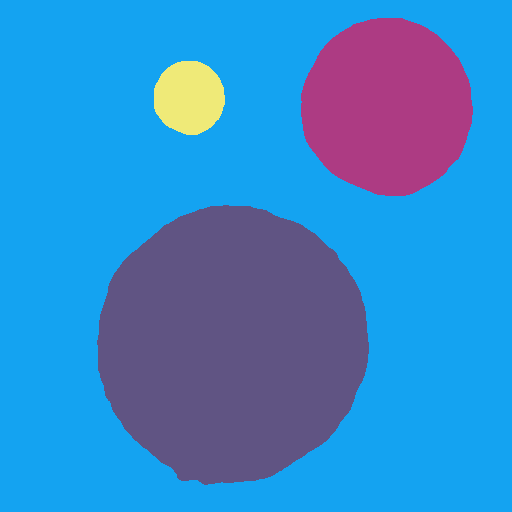

['a highly detailed photorealistic image of {a yellow ball:7924463}, {a blue ball:8606816} and {a green ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow ball'}}


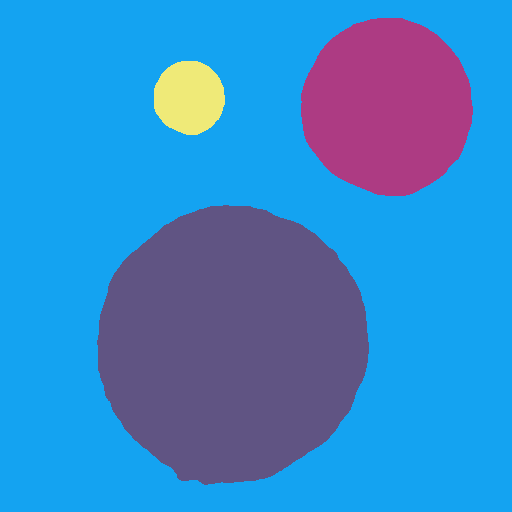

['a highly detailed photorealistic image of {a blue ball:7924463}, {a yellow ball:8606816} and {a white ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a blue ball'}}


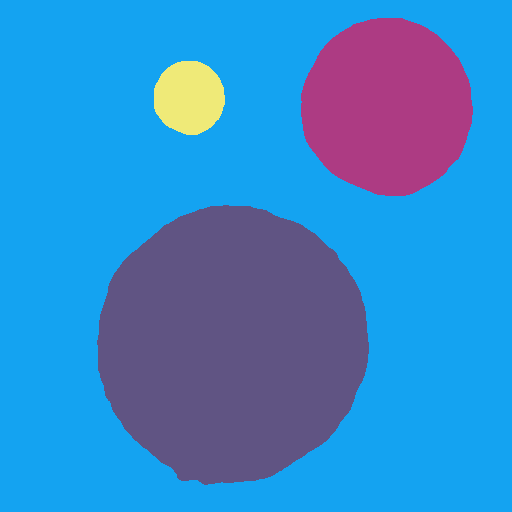

['a highly detailed photorealistic image of {a green ball:7924463}, {a white ball:8606816} and {a red ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a white ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green ball'}}


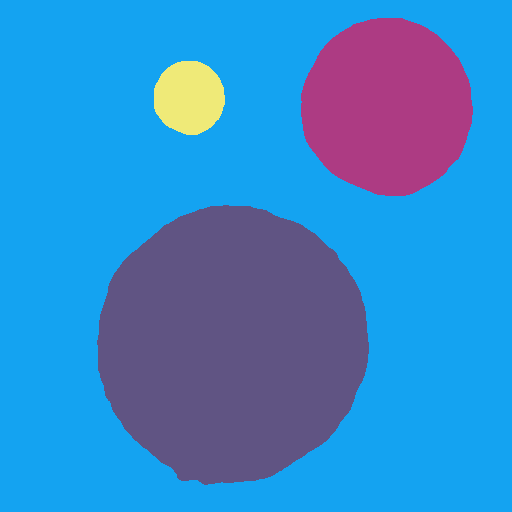

['a highly detailed photorealistic image of {a yellow ball:7924463}, {a red ball:8606816} and {a white ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow ball'}}


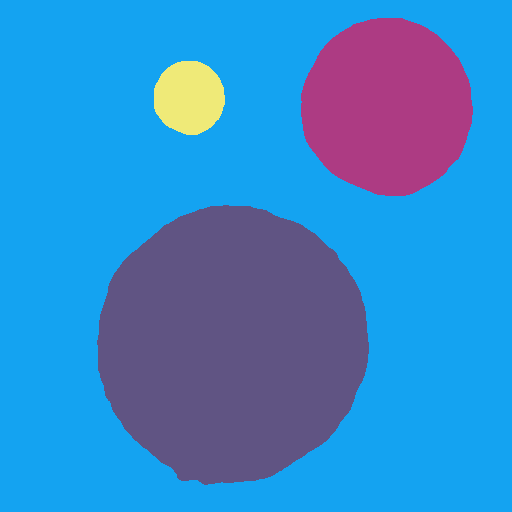

['a highly detailed photorealistic image of {a yellow ball:7924463}, {a red ball:8606816} and {a white ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow ball'}}


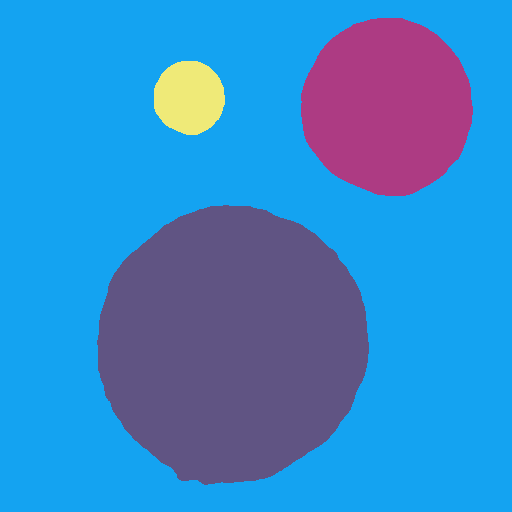

['a highly detailed photorealistic image of {a green ball:7924463}, {a red ball:8606816} and {a white ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green ball'}}


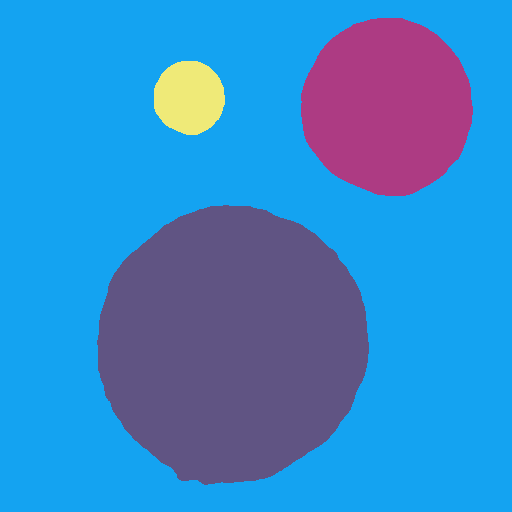

['a highly detailed photorealistic image of {a green ball:7924463}, {a yellow ball:8606816} and {a pink ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a pink ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green ball'}}


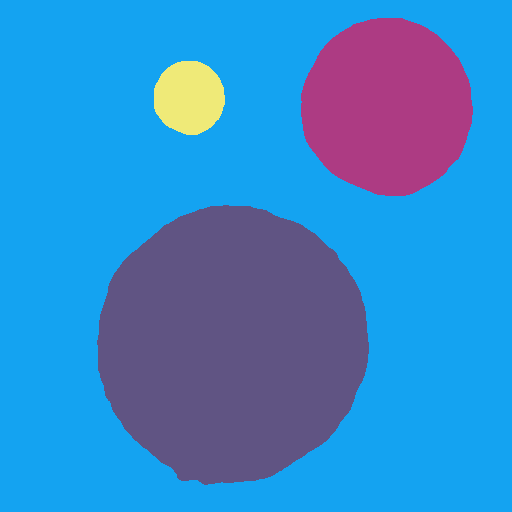

['a highly detailed photorealistic image of {a red ball:7924463}, {a pink ball:8606816} and {a white ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a pink ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red ball'}}


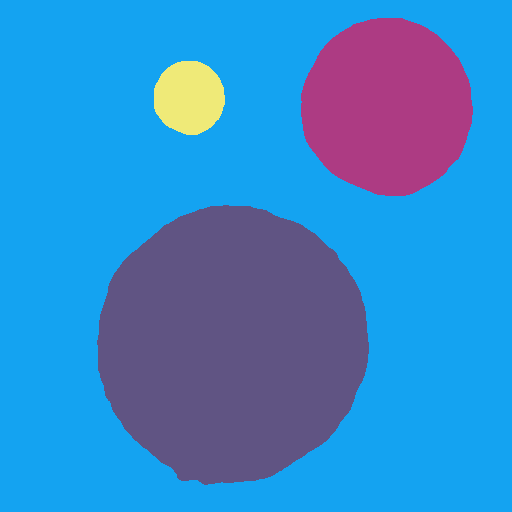

['a highly detailed photorealistic image of {a white ball:7924463}, {a yellow ball:8606816} and {a pink ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a pink ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a white ball'}}


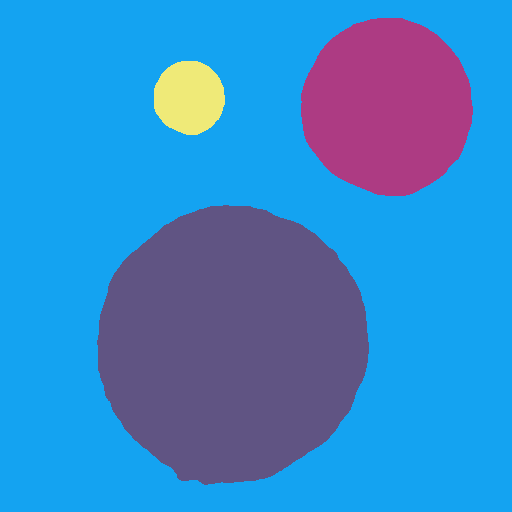

['a highly detailed photorealistic image of {a white ball:7924463}, {a blue ball:8606816} and {a red ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a white ball'}}


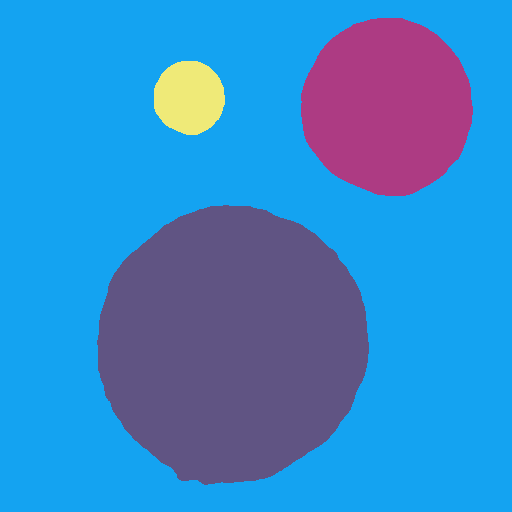

['a highly detailed photorealistic image of {a pink ball:7924463}, {a blue ball:8606816} and {a yellow ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pink ball'}}


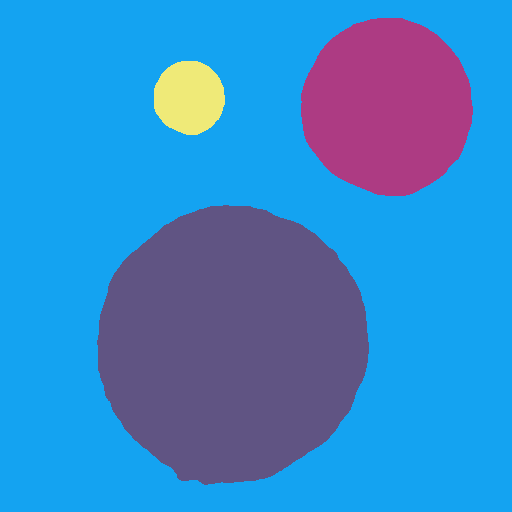

['a highly detailed photorealistic image of {a pink ball:7924463}, {a red ball:8606816} and {a white ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pink ball'}}


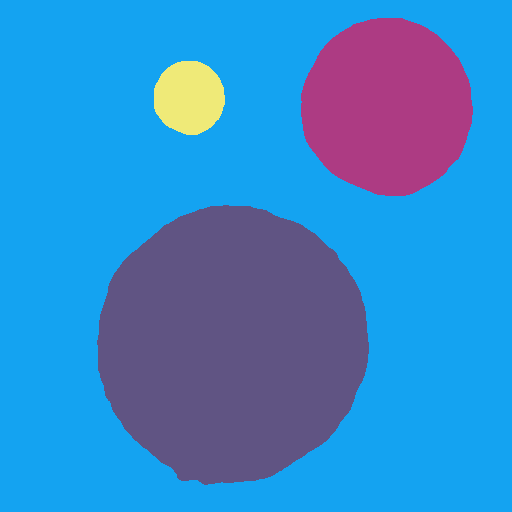

['a highly detailed photorealistic image of {a green ball:7924463}, {a pink ball:8606816} and {a red ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a pink ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green ball'}}


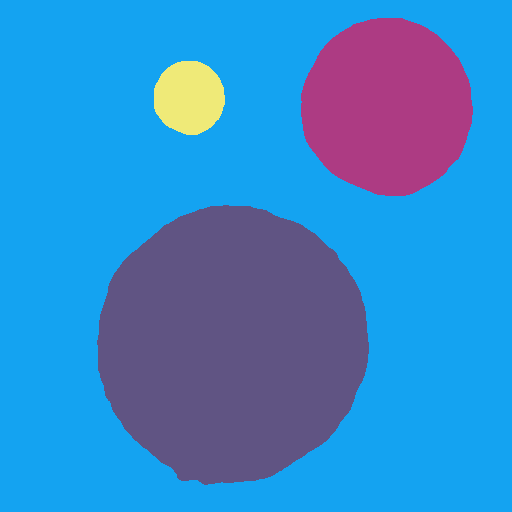

['a highly detailed photorealistic image of {a yellow ball:7924463}, {a red ball:8606816} and {a white ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow ball'}}


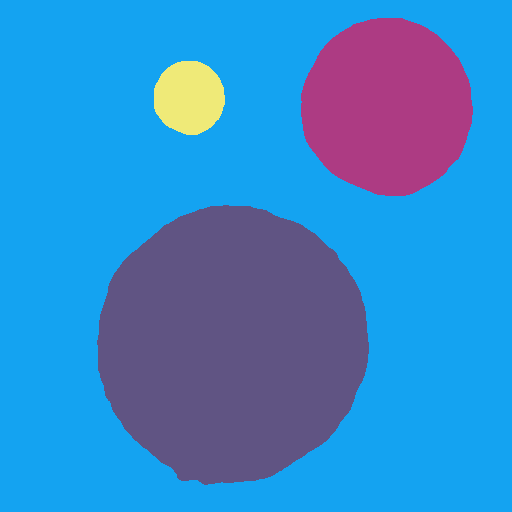

['a highly detailed photorealistic image of {a white ball:7924463}, {a pink ball:8606816} and {a green ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a pink ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a white ball'}}


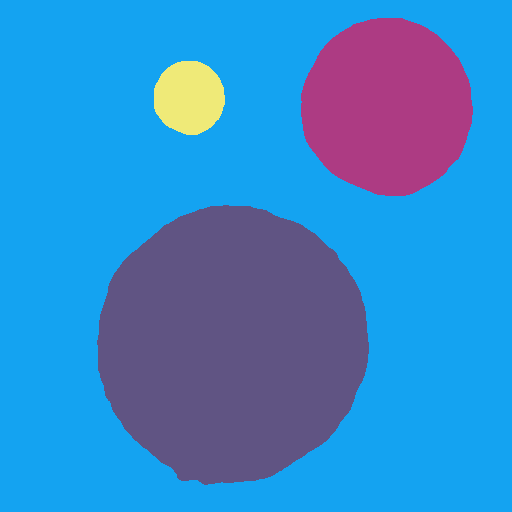

['a highly detailed photorealistic image of {a red ball:7924463}, {a yellow ball:8606816} and {a blue ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red ball'}}


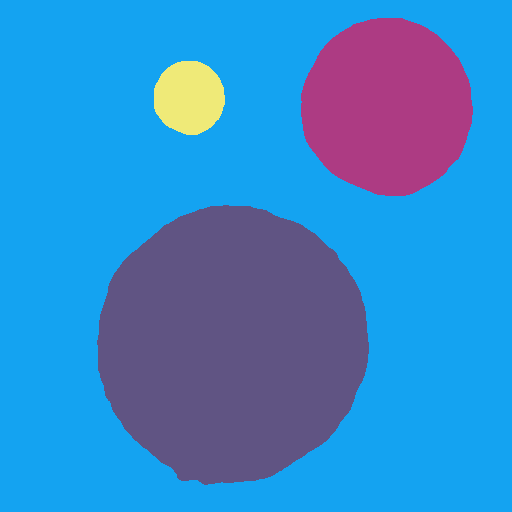

['a highly detailed photorealistic image of {a green ball:7924463}, {a yellow ball:8606816} and {a blue ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green ball'}}


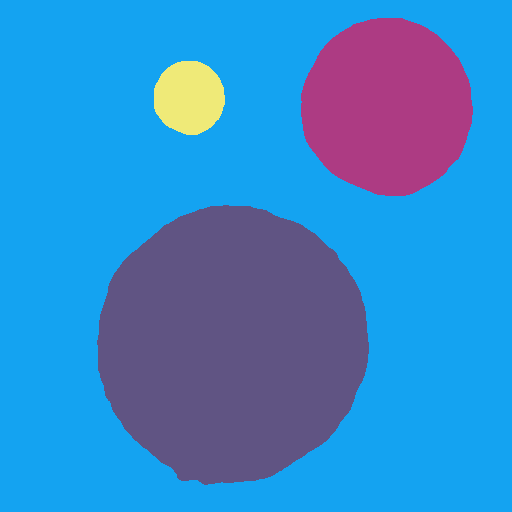

['a highly detailed photorealistic image of {a pink ball:7924463}, {a red ball:8606816} and {a white ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pink ball'}}


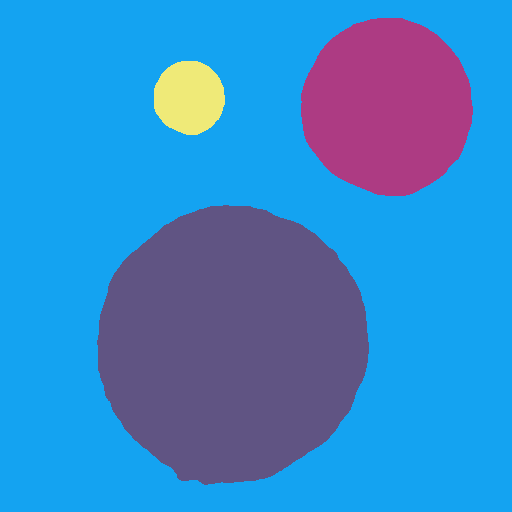

['a highly detailed photorealistic image of {a red ball:7924463}, {a yellow ball:8606816} and {a blue ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red ball'}}


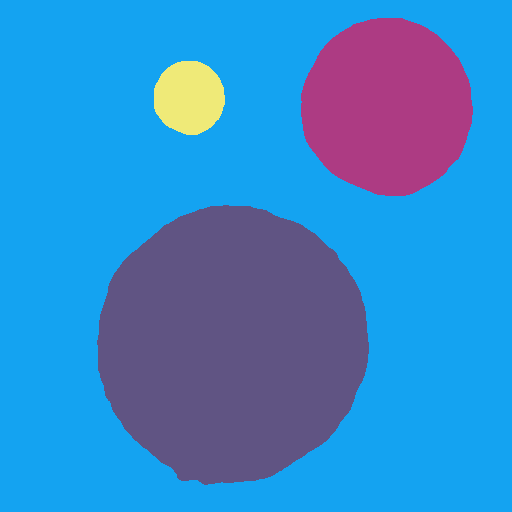

['a highly detailed photorealistic image of {a green ball:7924463}, {a white ball:8606816} and {a blue ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a white ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green ball'}}


In [83]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    display_example(x)
    examples.append(x)
    
Path("evaldata/").mkdir(exist_ok=True)
with open("evaldata/threecoloredballs1.pkl", "wb") as f:
    pkl.dump(examples, f)
    


In [58]:
# setting two: fruits
objects = ["a {color} orange", "a {color} apple", "a {color} watermelon"]
object_colors = ["red", "green", "yellow"]
backgrounds = ["a kitchen table", "grass", "a fruit basket"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        # print(objperm)
        for colorperm in itertools.permutations(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                spec[posname] = obj.format(color=color)
            specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
    
    
# iterate through possible combinations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    specset = set()
    for objperm in itertools.combinations_with_replacement(objects, 3):
        # print(objperm)
        _spec = deepcopy(spec)
        for colorperm in itertools.combinations_with_replacement(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                _spec[posname] = obj.format(color=color)
            specset = set(_spec.values())
            if len(specset) < len(_spec):
                continue
            specs.append(deepcopy(_spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
            

108
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a green watermelon', '<OBJ_B>': 'a yellow orange', '<OBJ_C>': 'a red apple'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a green apple', '<OBJ_B>': 'a red orange', '<OBJ_C>': 'a yellow watermelon'}
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a red orange', '<OBJ_B>': 'a yellow apple', '<OBJ_C>': 'a green watermelon'}
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a green watermelon', '<OBJ_B>': 'a red apple', '<OBJ_C>': 'a yellow orange'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a yellow apple', '<OBJ_B>': 'a red watermelon', '<OBJ_C>': 'a green orange'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a green orange', '<OBJ_B>': 'a red apple', '<OBJ_C>': 'a yellow watermelon'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a green orange', '<OBJ_B>': 'a yellow watermelon', '<OBJ_C>': 'a red apple'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a yellow orange', '<OBJ_B>': 'a green watermelon', '<OBJ_C>': 'a red apple'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a red apple', '<

In [59]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)

Path("evaldata").mkdir(exist_ok=True)
with open("evaldata/threefruits1.pkl", "wb") as f:
    pkl.dump(examples, f)
    


In [67]:
# setting two, version 2: simple fruits
objects = ["an orange", "a red apple", "a green apple", "a watermelon", "a kiwi", "a chestnut", "a walnut", "a peach", "a grape"]
backgrounds = ["a kitchen table", "grass"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        for posname, obj in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm):
            spec[posname] = obj.format(color=color)
        specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:20]
retspecs += specs

for spec in specs:
    print(spec)
    

1008
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a walnut', '<OBJ_B>': 'an orange', '<OBJ_C>': 'a watermelon'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a kiwi', '<OBJ_B>': 'a walnut', '<OBJ_C>': 'a peach'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a red apple', '<OBJ_B>': 'a kiwi', '<OBJ_C>': 'a watermelon'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a watermelon', '<OBJ_B>': 'an orange', '<OBJ_C>': 'a peach'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a grape', '<OBJ_B>': 'a walnut', '<OBJ_C>': 'a green apple'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a watermelon', '<OBJ_B>': 'a walnut', '<OBJ_C>': 'an orange'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a green apple', '<OBJ_B>': 'a peach', '<OBJ_C>': 'a grape'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'an orange', '<OBJ_B>': 'a kiwi', '<OBJ_C>': 'a green apple'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a watermelon', '<OBJ_B>': 'a grape', '<OBJ_C>': 'a chestnut'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a watermelon', '<OBJ_B>': 'a peach', '<OBJ_C>': 'a grape'}
{

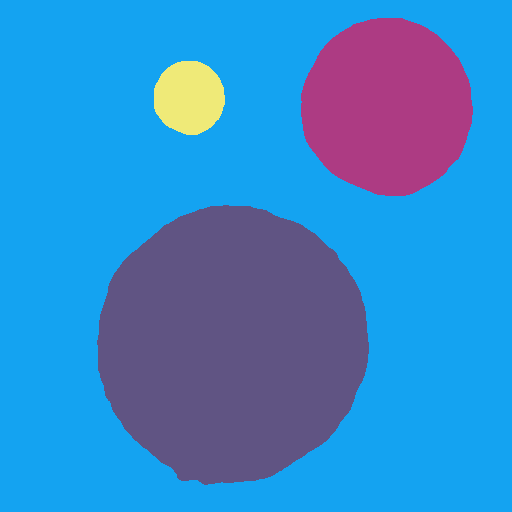

['a highly detailed photorealistic image of {a walnut:7924463}, {an orange:8606816} and {a watermelon:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of an orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a walnut'}}


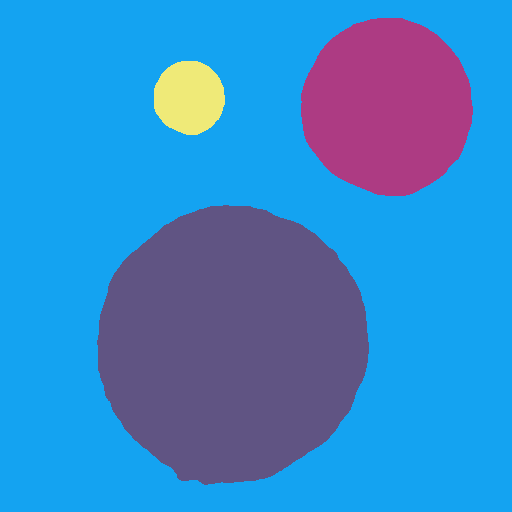

['a highly detailed photorealistic image of {a kiwi:7924463}, {a walnut:8606816} and {a peach:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a peach'}, 8606816: {'caption': 'a highly detailed photorealistic image of a walnut'}, 7924463: {'caption': 'a highly detailed photorealistic image of a kiwi'}}


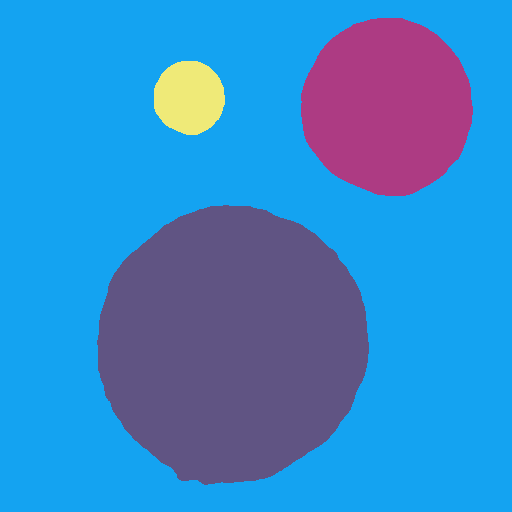

['a highly detailed photorealistic image of {a red apple:7924463}, {a kiwi:8606816} and {a watermelon:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a kiwi'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red apple'}}


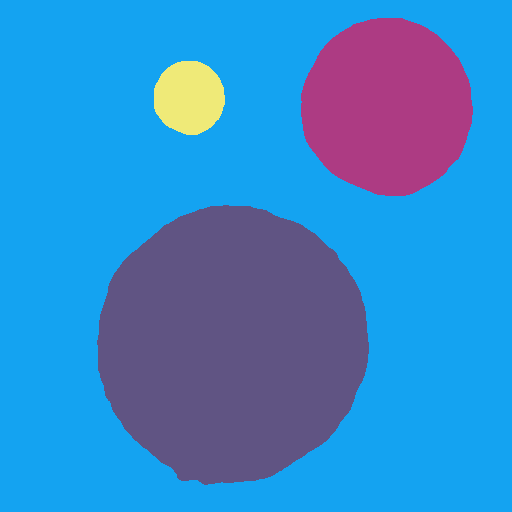

['a highly detailed photorealistic image of {a watermelon:7924463}, {an orange:8606816} and {a peach:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a peach'}, 8606816: {'caption': 'a highly detailed photorealistic image of an orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a watermelon'}}


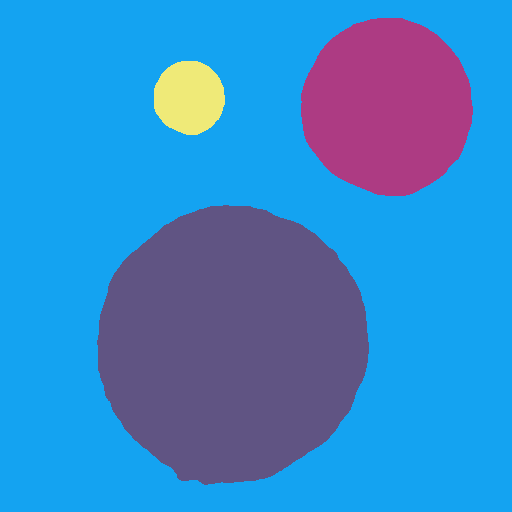

['a highly detailed photorealistic image of {a grape:7924463}, {a walnut:8606816} and {a green apple:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green apple'}, 8606816: {'caption': 'a highly detailed photorealistic image of a walnut'}, 7924463: {'caption': 'a highly detailed photorealistic image of a grape'}}


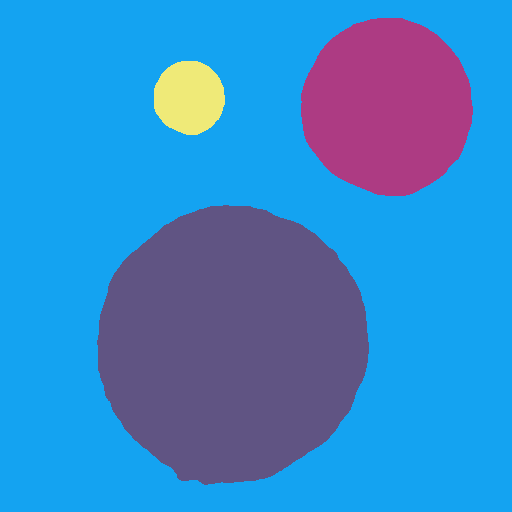

['a highly detailed photorealistic image of {a watermelon:7924463}, {a walnut:8606816} and {an orange:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of an orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of a walnut'}, 7924463: {'caption': 'a highly detailed photorealistic image of a watermelon'}}


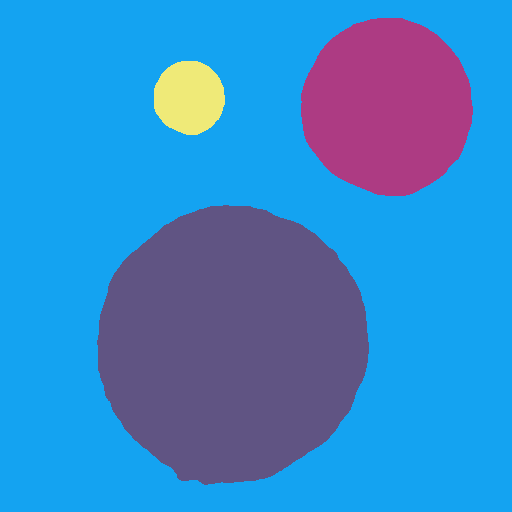

['a highly detailed photorealistic image of {a green apple:7924463}, {a peach:8606816} and {a grape:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a grape'}, 8606816: {'caption': 'a highly detailed photorealistic image of a peach'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green apple'}}


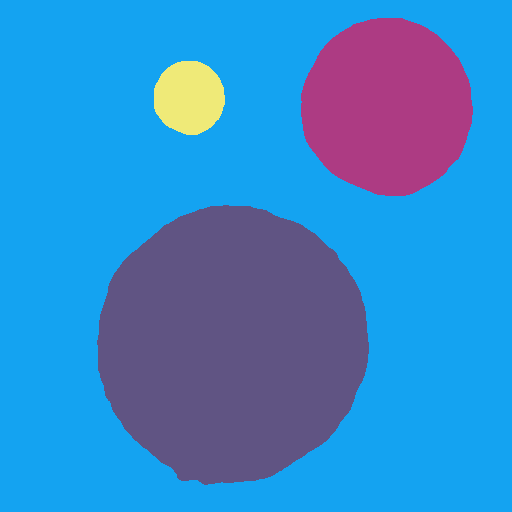

['a highly detailed photorealistic image of {an orange:7924463}, {a kiwi:8606816} and {a green apple:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green apple'}, 8606816: {'caption': 'a highly detailed photorealistic image of a kiwi'}, 7924463: {'caption': 'a highly detailed photorealistic image of an orange'}}


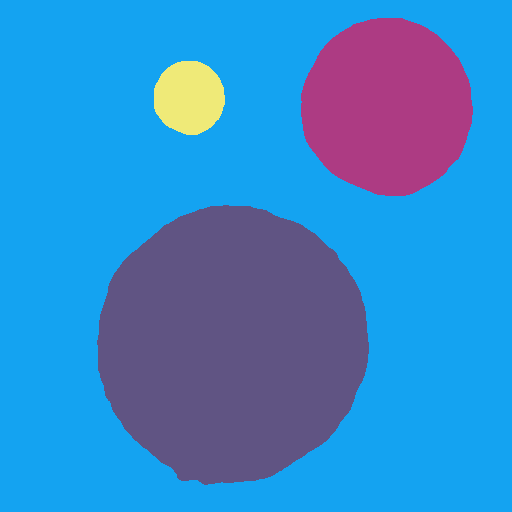

['a highly detailed photorealistic image of {a watermelon:7924463}, {a grape:8606816} and {a chestnut:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a chestnut'}, 8606816: {'caption': 'a highly detailed photorealistic image of a grape'}, 7924463: {'caption': 'a highly detailed photorealistic image of a watermelon'}}


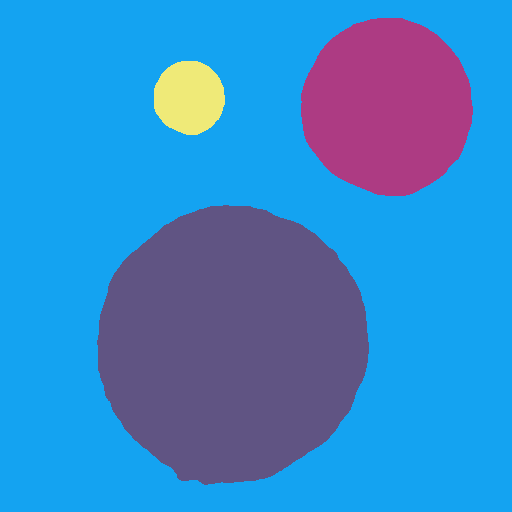

['a highly detailed photorealistic image of {a watermelon:7924463}, {a peach:8606816} and {a grape:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a grape'}, 8606816: {'caption': 'a highly detailed photorealistic image of a peach'}, 7924463: {'caption': 'a highly detailed photorealistic image of a watermelon'}}


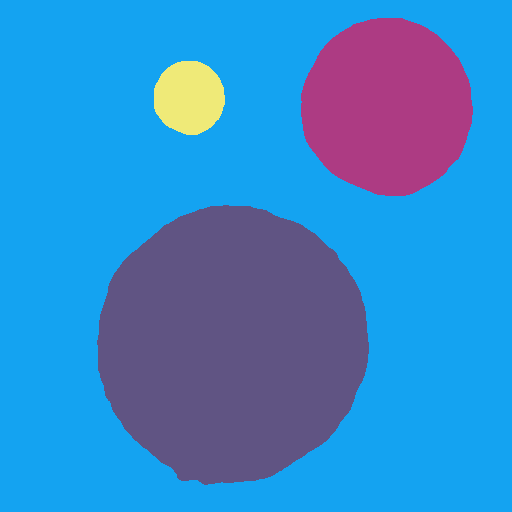

['a highly detailed photorealistic image of {a grape:7924463}, {a kiwi:8606816} and {a red apple:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red apple'}, 8606816: {'caption': 'a highly detailed photorealistic image of a kiwi'}, 7924463: {'caption': 'a highly detailed photorealistic image of a grape'}}


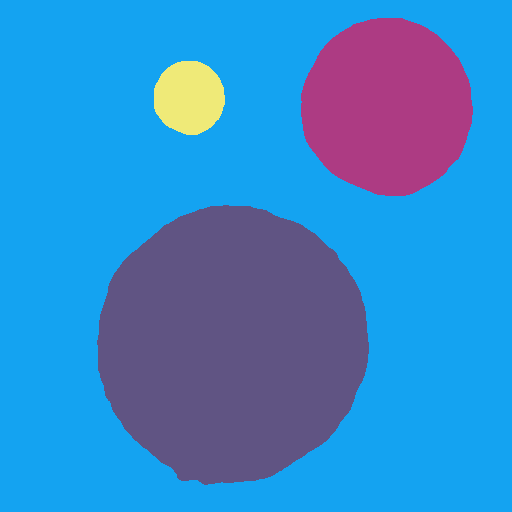

['a highly detailed photorealistic image of {a watermelon:7924463}, {a kiwi:8606816} and {a walnut:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a walnut'}, 8606816: {'caption': 'a highly detailed photorealistic image of a kiwi'}, 7924463: {'caption': 'a highly detailed photorealistic image of a watermelon'}}


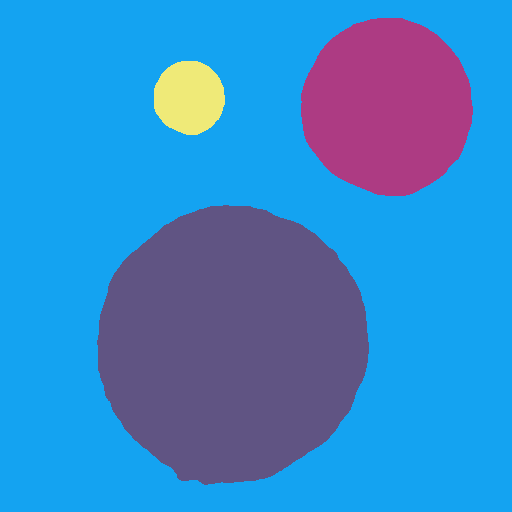

['a highly detailed photorealistic image of {an orange:7924463}, {a kiwi:8606816} and {a green apple:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green apple'}, 8606816: {'caption': 'a highly detailed photorealistic image of a kiwi'}, 7924463: {'caption': 'a highly detailed photorealistic image of an orange'}}


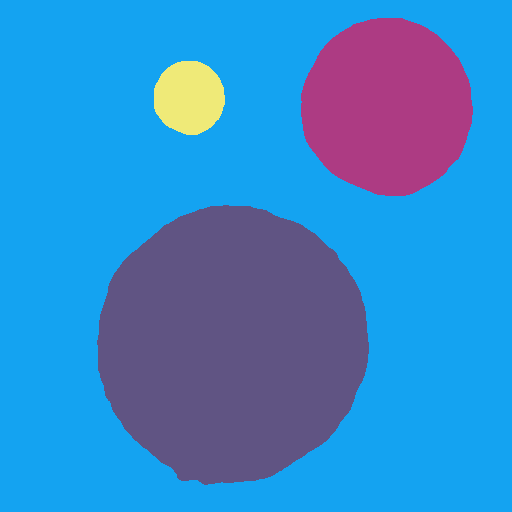

['a highly detailed photorealistic image of {a green apple:7924463}, {a red apple:8606816} and {an orange:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of an orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green apple'}}


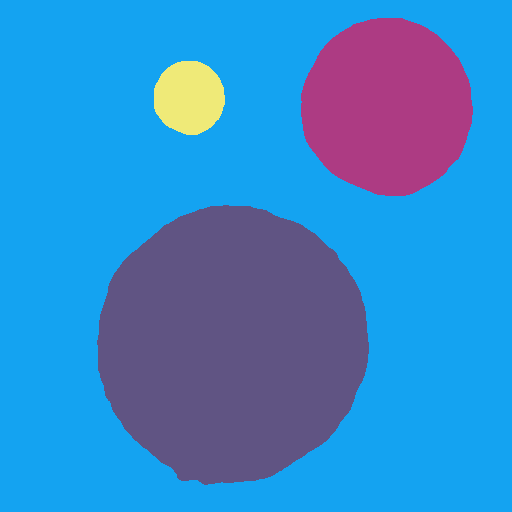

['a highly detailed photorealistic image of {a peach:7924463}, {a watermelon:8606816} and {a red apple:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red apple'}, 8606816: {'caption': 'a highly detailed photorealistic image of a watermelon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a peach'}}


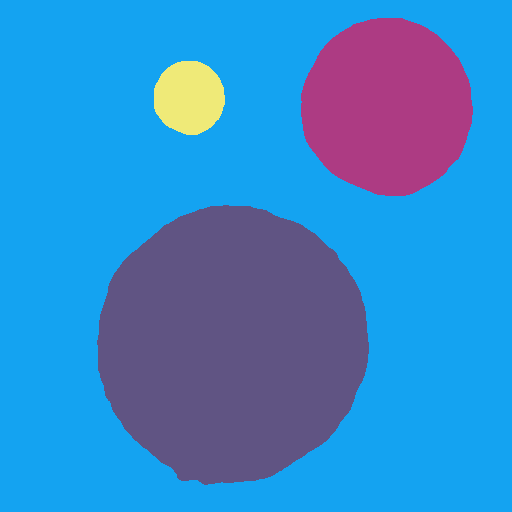

['a highly detailed photorealistic image of {a red apple:7924463}, {an orange:8606816} and {a kiwi:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a kiwi'}, 8606816: {'caption': 'a highly detailed photorealistic image of an orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red apple'}}


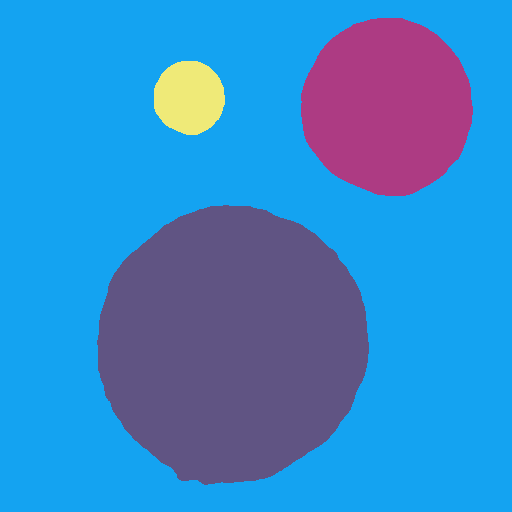

['a highly detailed photorealistic image of {a red apple:7924463}, {a grape:8606816} and {a chestnut:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a chestnut'}, 8606816: {'caption': 'a highly detailed photorealistic image of a grape'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red apple'}}


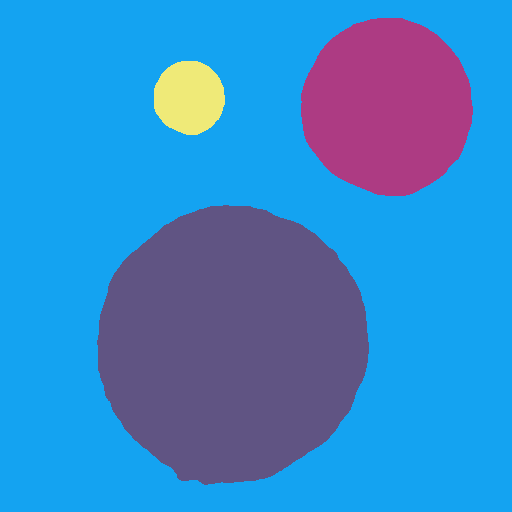

['a highly detailed photorealistic image of {a grape:7924463}, {a watermelon:8606816} and {a kiwi:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a kiwi'}, 8606816: {'caption': 'a highly detailed photorealistic image of a watermelon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a grape'}}


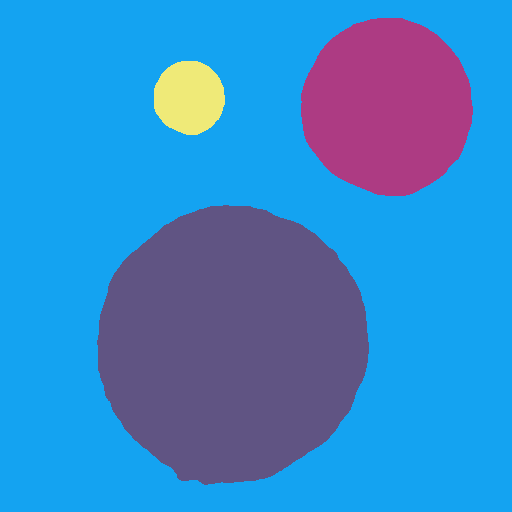

['a highly detailed photorealistic image of {a green apple:7924463}, {a red apple:8606816} and {a walnut:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a walnut'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green apple'}}


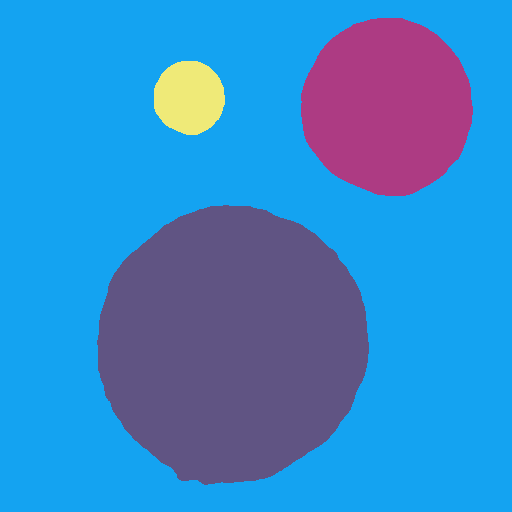

['a highly detailed photorealistic image of {a grape:7924463}, {a chestnut:8606816} and {a peach:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a peach'}, 8606816: {'caption': 'a highly detailed photorealistic image of a chestnut'}, 7924463: {'caption': 'a highly detailed photorealistic image of a grape'}}


In [69]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    #display_example(x)
    examples.append(x)

Path("evaldata").mkdir(exist_ok=True)
with open("evaldata/threesimplefruits1.pkl", "wb") as f:
    pkl.dump(examples, f)
    


In [101]:
# setting two, version 2: all yellow
objects = ["a lemon", "a gold coin", "cheese wheel", "a yellow smiley face pin", "a yellow pancake", "a dandelion", "a slice of banana"]
backgrounds = ["a wooden table"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        for posname, obj in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm):
            spec[posname] = obj.format(color=color)
        specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:20]
retspecs += specs

for spec in specs:
    print(spec)
    

210
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow smiley face pin', '<OBJ_B>': 'a lemon', '<OBJ_C>': 'a dandelion'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a slice of banana', '<OBJ_B>': 'cheese wheel', '<OBJ_C>': 'a yellow pancake'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a lemon', '<OBJ_B>': 'a yellow smiley face pin', '<OBJ_C>': 'a yellow pancake'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a gold coin', '<OBJ_B>': 'cheese wheel', '<OBJ_C>': 'a yellow pancake'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow pancake', '<OBJ_B>': 'a dandelion', '<OBJ_C>': 'a yellow smiley face pin'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow pancake', '<OBJ_B>': 'a lemon', '<OBJ_C>': 'a yellow smiley face pin'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a gold coin', '<OBJ_B>': 'a yellow smiley face pin', '<OBJ_C>': 'a dandelion'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'cheese wheel', '<OBJ_B>': 'a dandelion', '<OBJ_C>': 'a lemon'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a gold 

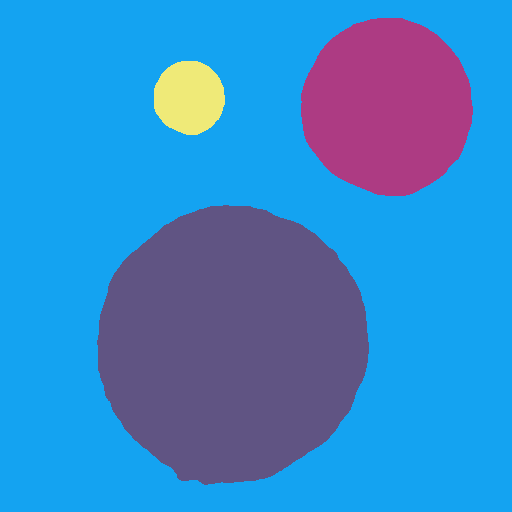

['a highly detailed photorealistic image of {a yellow smiley face pin:7924463}, {a lemon:8606816} and {a dandelion:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a dandelion'}, 8606816: {'caption': 'a highly detailed photorealistic image of a lemon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow smiley face pin'}}


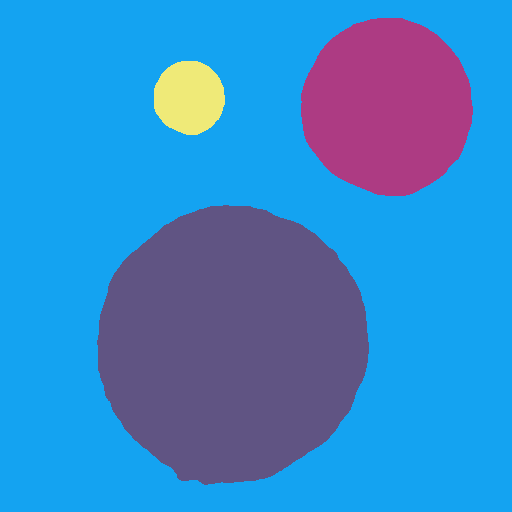

['a highly detailed photorealistic image of {a slice of banana:7924463}, {cheese wheel:8606816} and {a yellow pancake:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow pancake'}, 8606816: {'caption': 'a highly detailed photorealistic image of cheese wheel'}, 7924463: {'caption': 'a highly detailed photorealistic image of a slice of banana'}}


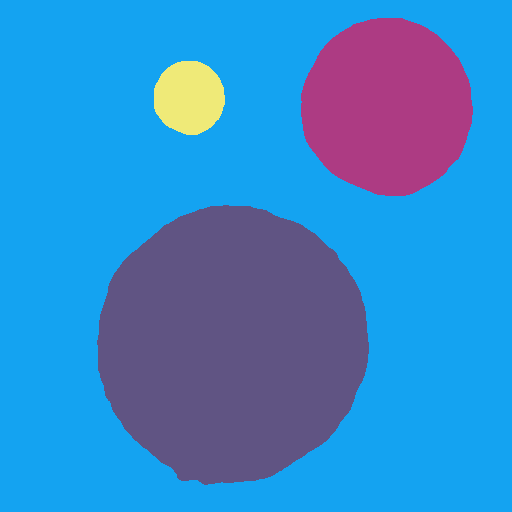

['a highly detailed photorealistic image of {a lemon:7924463}, {a yellow smiley face pin:8606816} and {a yellow pancake:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow pancake'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow smiley face pin'}, 7924463: {'caption': 'a highly detailed photorealistic image of a lemon'}}


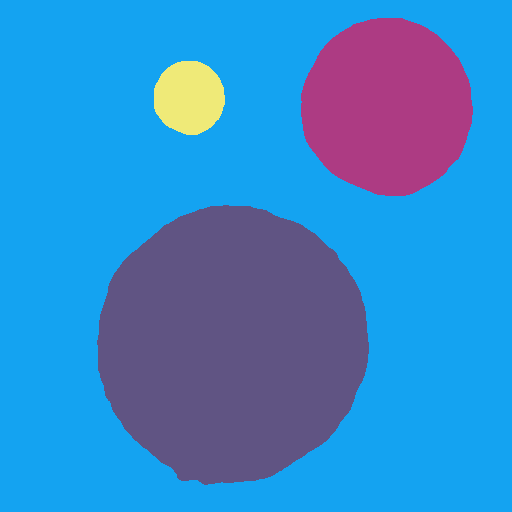

['a highly detailed photorealistic image of {a gold coin:7924463}, {cheese wheel:8606816} and {a yellow pancake:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow pancake'}, 8606816: {'caption': 'a highly detailed photorealistic image of cheese wheel'}, 7924463: {'caption': 'a highly detailed photorealistic image of a gold coin'}}


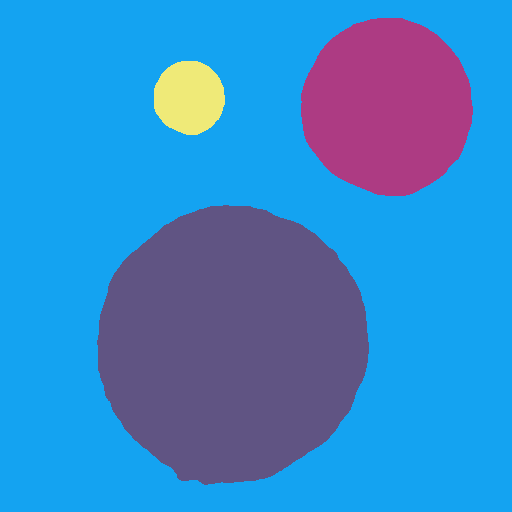

['a highly detailed photorealistic image of {a yellow pancake:7924463}, {a dandelion:8606816} and {a yellow smiley face pin:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow smiley face pin'}, 8606816: {'caption': 'a highly detailed photorealistic image of a dandelion'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow pancake'}}


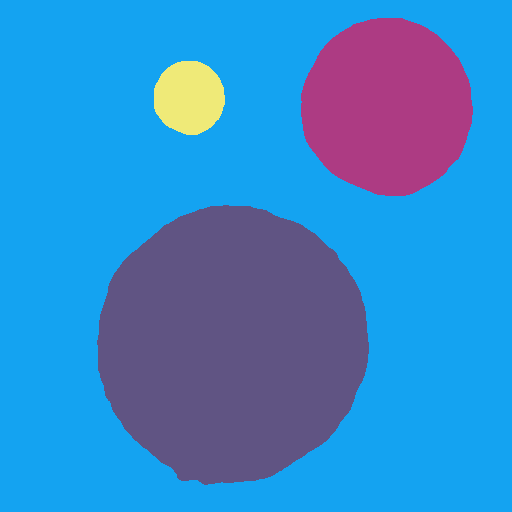

['a highly detailed photorealistic image of {a yellow pancake:7924463}, {a lemon:8606816} and {a yellow smiley face pin:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow smiley face pin'}, 8606816: {'caption': 'a highly detailed photorealistic image of a lemon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow pancake'}}


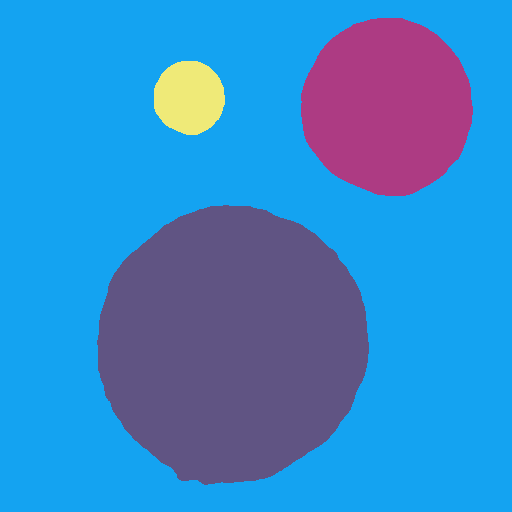

['a highly detailed photorealistic image of {a gold coin:7924463}, {a yellow smiley face pin:8606816} and {a dandelion:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a dandelion'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow smiley face pin'}, 7924463: {'caption': 'a highly detailed photorealistic image of a gold coin'}}


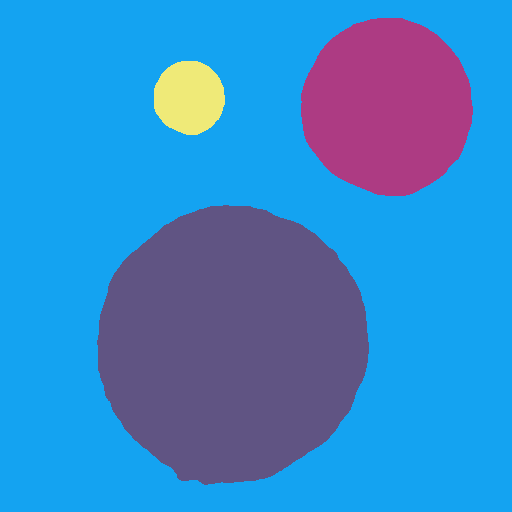

['a highly detailed photorealistic image of {cheese wheel:7924463}, {a dandelion:8606816} and {a lemon:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a lemon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a dandelion'}, 7924463: {'caption': 'a highly detailed photorealistic image of cheese wheel'}}


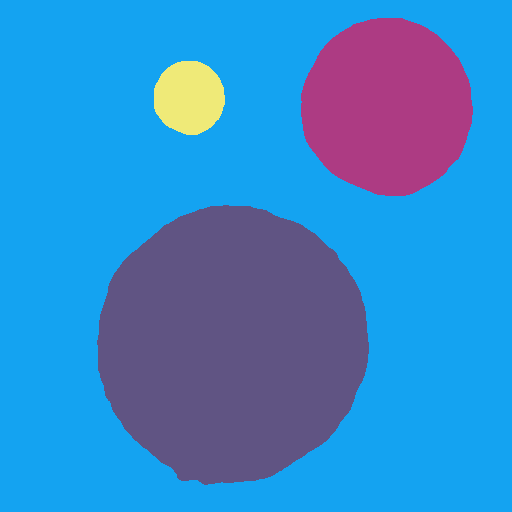

['a highly detailed photorealistic image of {a gold coin:7924463}, {a yellow pancake:8606816} and {a slice of banana:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a slice of banana'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow pancake'}, 7924463: {'caption': 'a highly detailed photorealistic image of a gold coin'}}


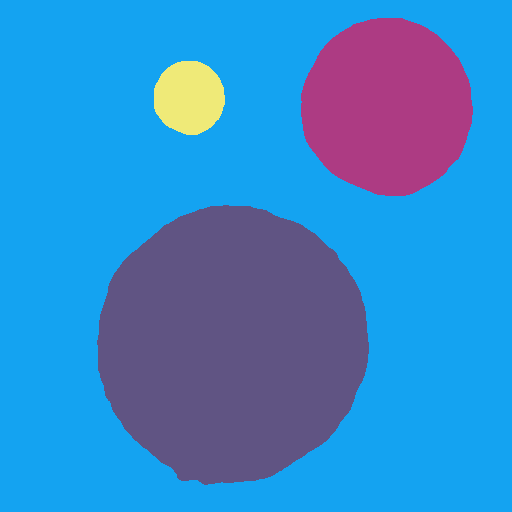

['a highly detailed photorealistic image of {a gold coin:7924463}, {a yellow pancake:8606816} and {a yellow smiley face pin:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow smiley face pin'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow pancake'}, 7924463: {'caption': 'a highly detailed photorealistic image of a gold coin'}}


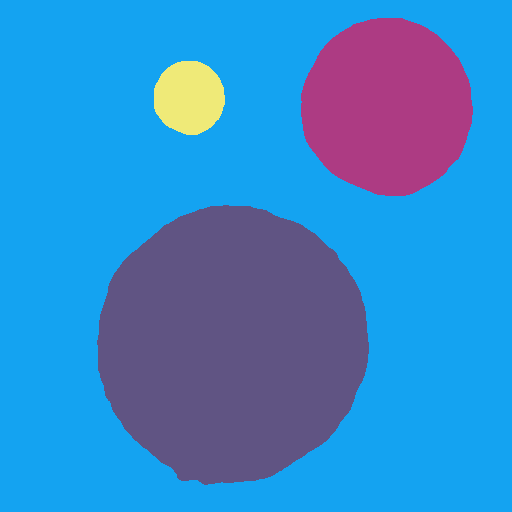

['a highly detailed photorealistic image of {a yellow pancake:7924463}, {a lemon:8606816} and {a slice of banana:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a slice of banana'}, 8606816: {'caption': 'a highly detailed photorealistic image of a lemon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow pancake'}}


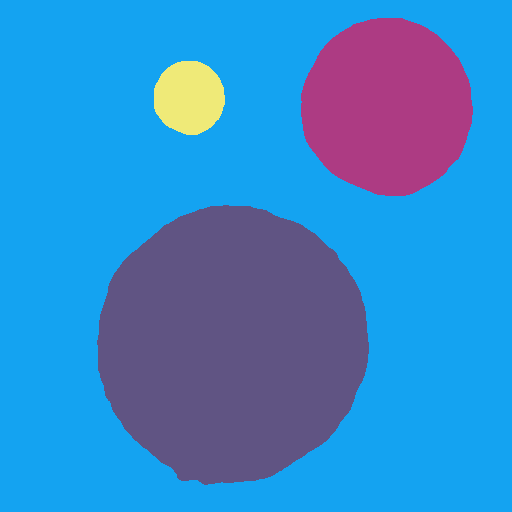

['a highly detailed photorealistic image of {a slice of banana:7924463}, {a yellow smiley face pin:8606816} and {cheese wheel:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of cheese wheel'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow smiley face pin'}, 7924463: {'caption': 'a highly detailed photorealistic image of a slice of banana'}}


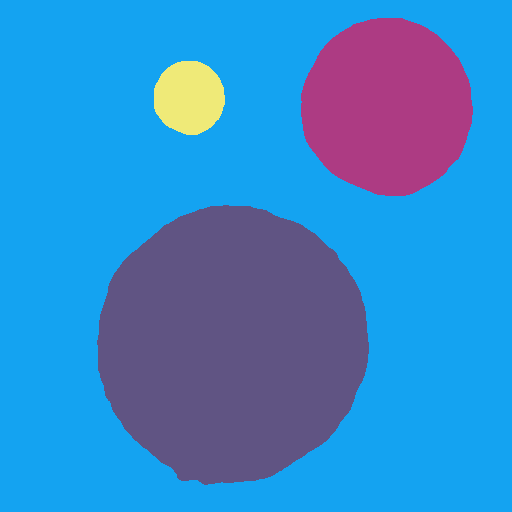

['a highly detailed photorealistic image of {a dandelion:7924463}, {a yellow smiley face pin:8606816} and {a yellow pancake:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow pancake'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow smiley face pin'}, 7924463: {'caption': 'a highly detailed photorealistic image of a dandelion'}}


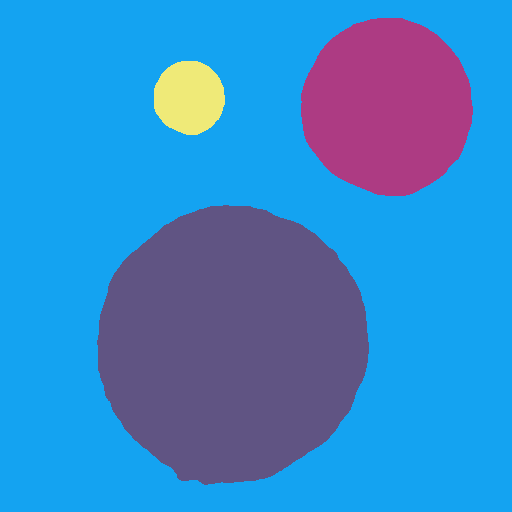

['a highly detailed photorealistic image of {a gold coin:7924463}, {a yellow pancake:8606816} and {cheese wheel:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of cheese wheel'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow pancake'}, 7924463: {'caption': 'a highly detailed photorealistic image of a gold coin'}}


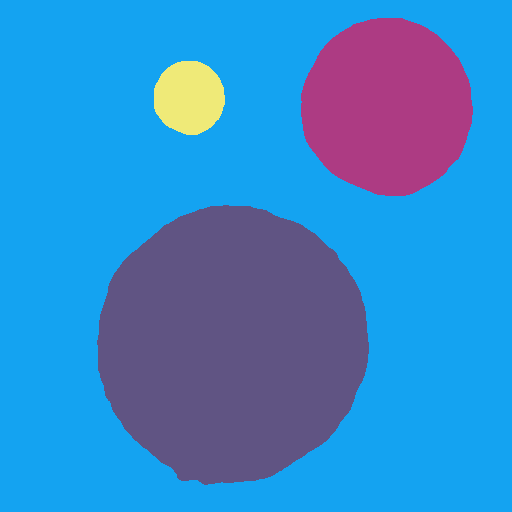

['a highly detailed photorealistic image of {cheese wheel:7924463}, {a lemon:8606816} and {a slice of banana:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a slice of banana'}, 8606816: {'caption': 'a highly detailed photorealistic image of a lemon'}, 7924463: {'caption': 'a highly detailed photorealistic image of cheese wheel'}}


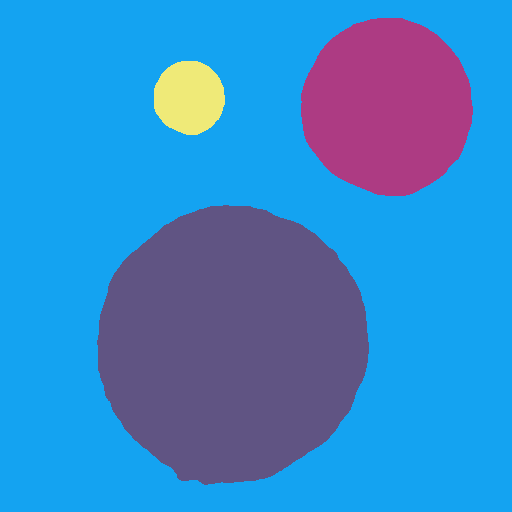

['a highly detailed photorealistic image of {a lemon:7924463}, {a slice of banana:8606816} and {a yellow smiley face pin:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow smiley face pin'}, 8606816: {'caption': 'a highly detailed photorealistic image of a slice of banana'}, 7924463: {'caption': 'a highly detailed photorealistic image of a lemon'}}


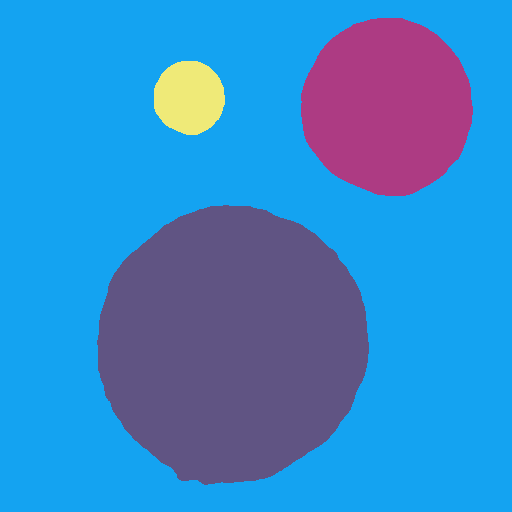

['a highly detailed photorealistic image of {a yellow smiley face pin:7924463}, {a lemon:8606816} and {cheese wheel:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of cheese wheel'}, 8606816: {'caption': 'a highly detailed photorealistic image of a lemon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow smiley face pin'}}


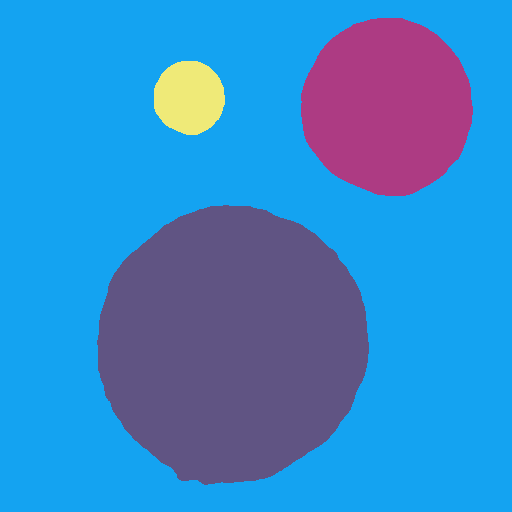

['a highly detailed photorealistic image of {a dandelion:7924463}, {a lemon:8606816} and {a slice of banana:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a slice of banana'}, 8606816: {'caption': 'a highly detailed photorealistic image of a lemon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a dandelion'}}


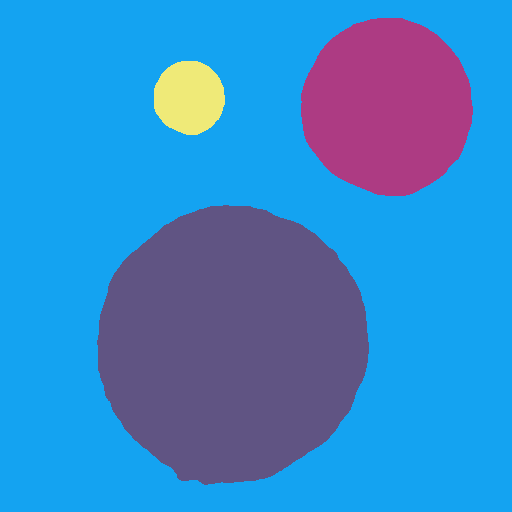

['a highly detailed photorealistic image of {cheese wheel:7924463}, {a slice of banana:8606816} and {a dandelion:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a dandelion'}, 8606816: {'caption': 'a highly detailed photorealistic image of a slice of banana'}, 7924463: {'caption': 'a highly detailed photorealistic image of cheese wheel'}}


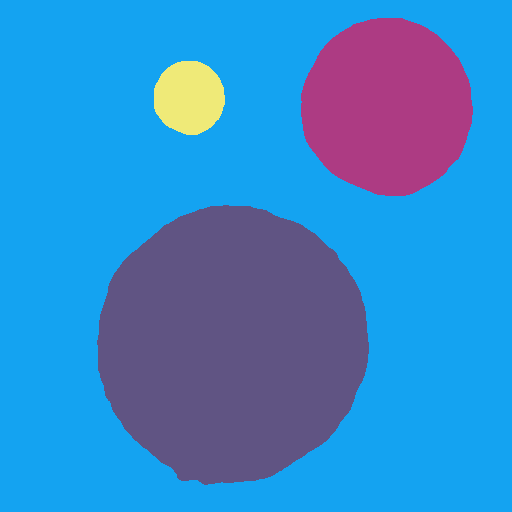

['a highly detailed photorealistic image of {a dandelion:7924463}, {a slice of banana:8606816} and {a gold coin:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a gold coin'}, 8606816: {'caption': 'a highly detailed photorealistic image of a slice of banana'}, 7924463: {'caption': 'a highly detailed photorealistic image of a dandelion'}}


In [103]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    display_example(x)
    examples.append(x)

Path("evaldata").mkdir(exist_ok=True)
with open("evaldata/threeyellow1.pkl", "wb") as f:
    pkl.dump(examples, f)
    


In [120]:
# setting two, version 2: all oranges
objects = ["an orange", "a pumpkin", "an apricot", "a persimmon", "donald trump's face"]
backgrounds = ["a wooden table"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        for posname, obj in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm):
            spec[posname] = obj.format(color=color)
        if objects[-1] in spec.values():
            if random.random() < 1.1: #0.9:
                continue
        if objects[-1] == spec["<OBJ_A>"] or objects[-1] == spec["<OBJ_C>"]:
            continue
        specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:20]
retspecs += specs

for spec in specs:
    print(spec)
    

24
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a pumpkin', '<OBJ_B>': 'a persimmon', '<OBJ_C>': 'an apricot'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a persimmon', '<OBJ_B>': 'a pumpkin', '<OBJ_C>': 'an orange'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a pumpkin', '<OBJ_B>': 'an apricot', '<OBJ_C>': 'an orange'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'an apricot', '<OBJ_B>': 'a pumpkin', '<OBJ_C>': 'an orange'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'an apricot', '<OBJ_B>': 'a pumpkin', '<OBJ_C>': 'a persimmon'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a persimmon', '<OBJ_B>': 'a pumpkin', '<OBJ_C>': 'an apricot'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'an orange', '<OBJ_B>': 'a persimmon', '<OBJ_C>': 'an apricot'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'an apricot', '<OBJ_B>': 'a persimmon', '<OBJ_C>': 'an orange'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'an apricot', '<OBJ_B>': 'an orange', '<OBJ_C>': 'a persimmon'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a pumpkin', '<O

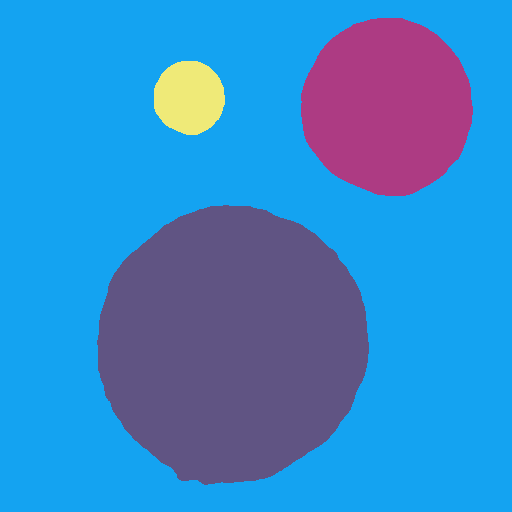

['a highly detailed photorealistic image of {a pumpkin:7924463}, {a persimmon:8606816} and {an apricot:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an apricot'}, 8606816: {'caption': 'a highly detailed photorealistic image of a persimmon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pumpkin'}}


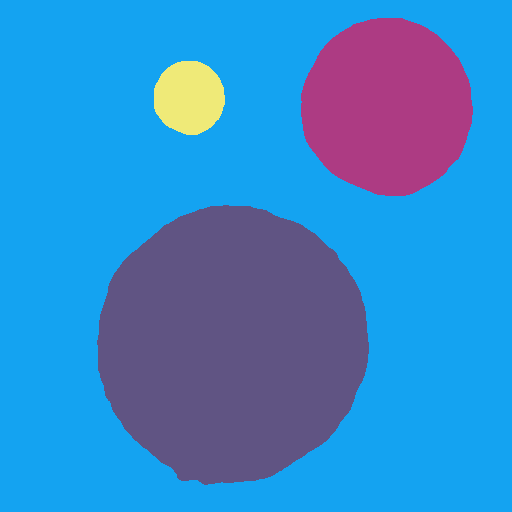

['a highly detailed photorealistic image of {a persimmon:7924463}, {a pumpkin:8606816} and {an orange:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of a pumpkin'}, 7924463: {'caption': 'a highly detailed photorealistic image of a persimmon'}}


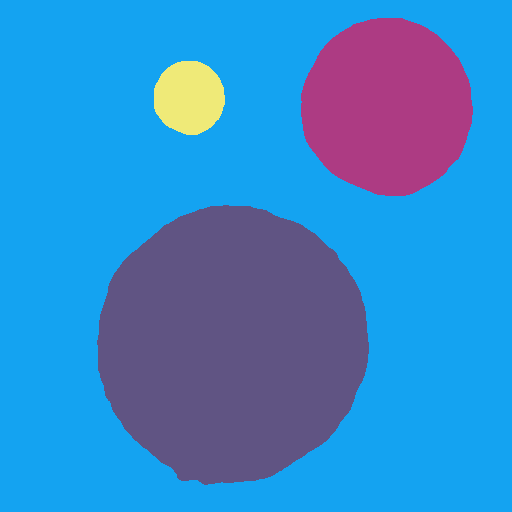

['a highly detailed photorealistic image of {a pumpkin:7924463}, {an apricot:8606816} and {an orange:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of an apricot'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pumpkin'}}


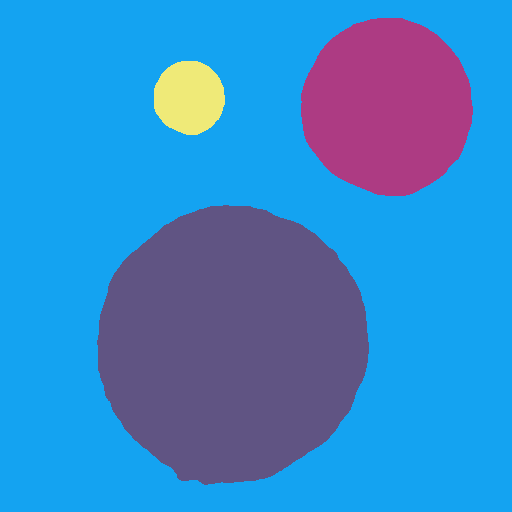

['a highly detailed photorealistic image of {an apricot:7924463}, {a pumpkin:8606816} and {an orange:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of a pumpkin'}, 7924463: {'caption': 'a highly detailed photorealistic image of an apricot'}}


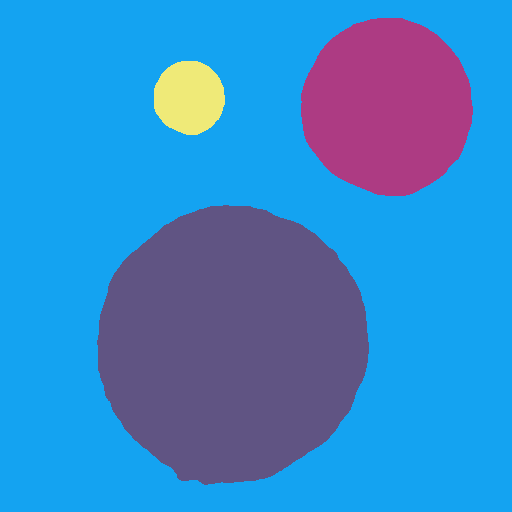

['a highly detailed photorealistic image of {an apricot:7924463}, {a pumpkin:8606816} and {a persimmon:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a persimmon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a pumpkin'}, 7924463: {'caption': 'a highly detailed photorealistic image of an apricot'}}


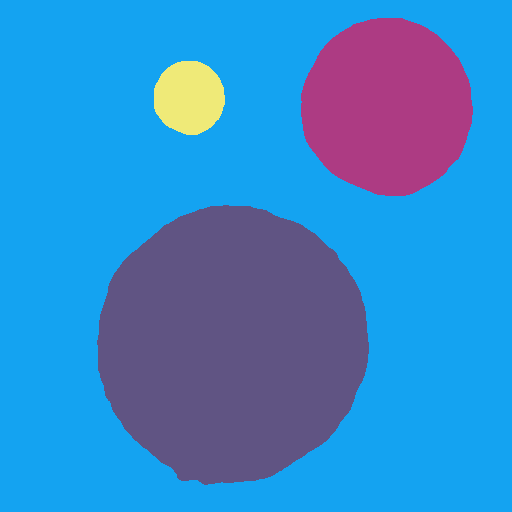

['a highly detailed photorealistic image of {a persimmon:7924463}, {a pumpkin:8606816} and {an apricot:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an apricot'}, 8606816: {'caption': 'a highly detailed photorealistic image of a pumpkin'}, 7924463: {'caption': 'a highly detailed photorealistic image of a persimmon'}}


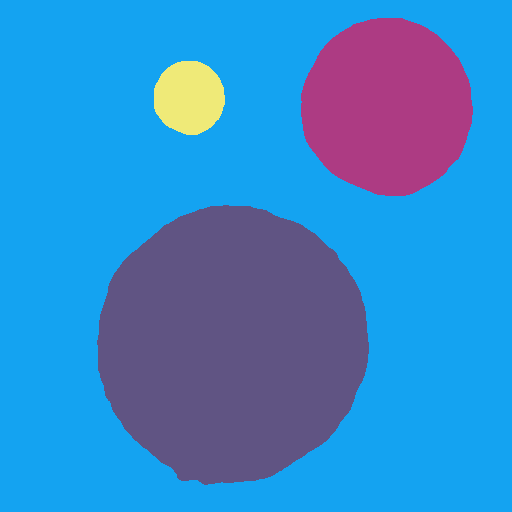

['a highly detailed photorealistic image of {an orange:7924463}, {a persimmon:8606816} and {an apricot:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an apricot'}, 8606816: {'caption': 'a highly detailed photorealistic image of a persimmon'}, 7924463: {'caption': 'a highly detailed photorealistic image of an orange'}}


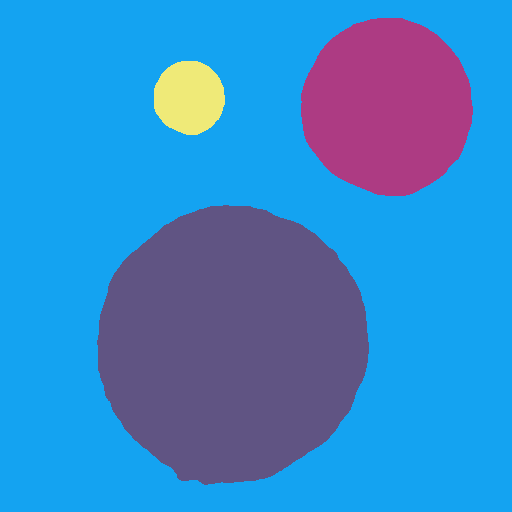

['a highly detailed photorealistic image of {an apricot:7924463}, {a persimmon:8606816} and {an orange:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of a persimmon'}, 7924463: {'caption': 'a highly detailed photorealistic image of an apricot'}}


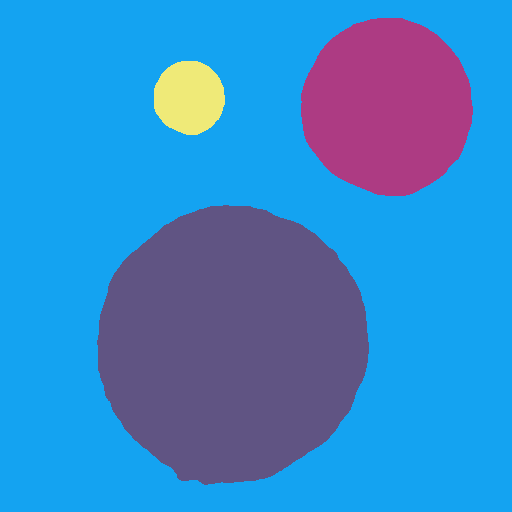

['a highly detailed photorealistic image of {an apricot:7924463}, {an orange:8606816} and {a persimmon:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a persimmon'}, 8606816: {'caption': 'a highly detailed photorealistic image of an orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of an apricot'}}


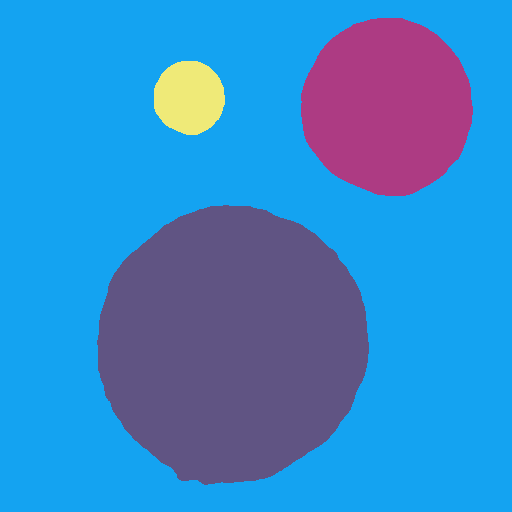

['a highly detailed photorealistic image of {a pumpkin:7924463}, {an orange:8606816} and {an apricot:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an apricot'}, 8606816: {'caption': 'a highly detailed photorealistic image of an orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pumpkin'}}


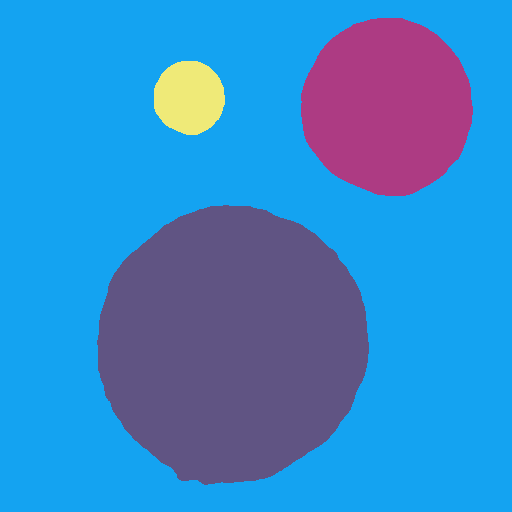

['a highly detailed photorealistic image of {a persimmon:7924463}, {an apricot:8606816} and {a pumpkin:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a pumpkin'}, 8606816: {'caption': 'a highly detailed photorealistic image of an apricot'}, 7924463: {'caption': 'a highly detailed photorealistic image of a persimmon'}}


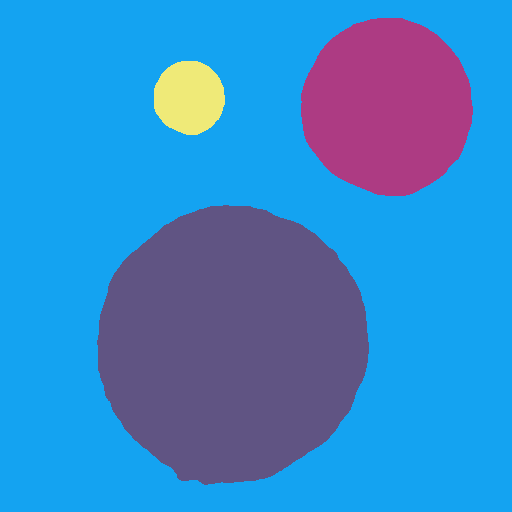

['a highly detailed photorealistic image of {a pumpkin:7924463}, {an orange:8606816} and {a persimmon:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a persimmon'}, 8606816: {'caption': 'a highly detailed photorealistic image of an orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pumpkin'}}


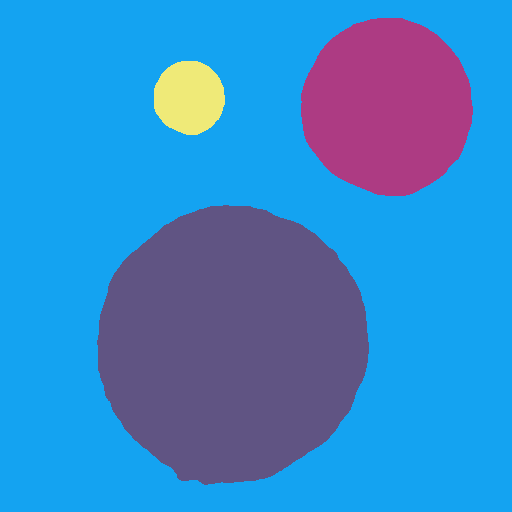

['a highly detailed photorealistic image of {an apricot:7924463}, {a persimmon:8606816} and {a pumpkin:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a pumpkin'}, 8606816: {'caption': 'a highly detailed photorealistic image of a persimmon'}, 7924463: {'caption': 'a highly detailed photorealistic image of an apricot'}}


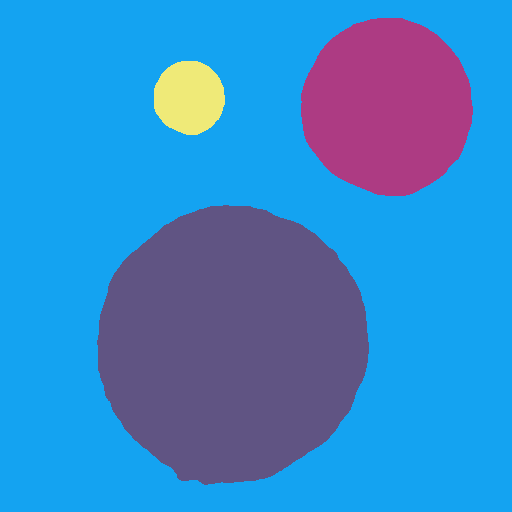

['a highly detailed photorealistic image of {an orange:7924463}, {an apricot:8606816} and {a persimmon:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a persimmon'}, 8606816: {'caption': 'a highly detailed photorealistic image of an apricot'}, 7924463: {'caption': 'a highly detailed photorealistic image of an orange'}}


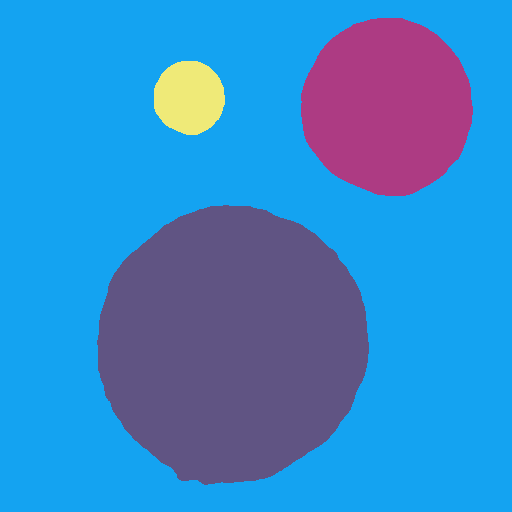

['a highly detailed photorealistic image of {an orange:7924463}, {a persimmon:8606816} and {a pumpkin:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a pumpkin'}, 8606816: {'caption': 'a highly detailed photorealistic image of a persimmon'}, 7924463: {'caption': 'a highly detailed photorealistic image of an orange'}}


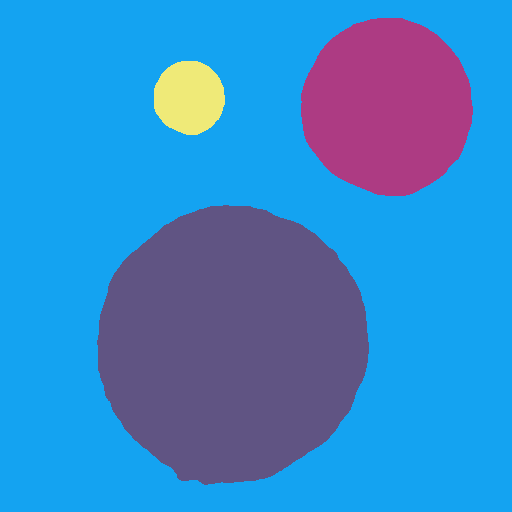

['a highly detailed photorealistic image of {a persimmon:7924463}, {an orange:8606816} and {a pumpkin:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a pumpkin'}, 8606816: {'caption': 'a highly detailed photorealistic image of an orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a persimmon'}}


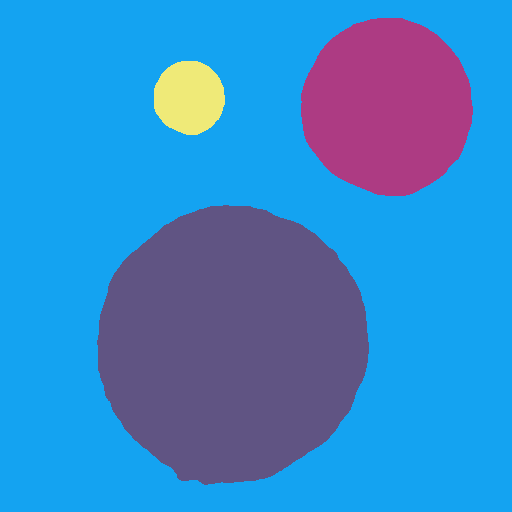

['a highly detailed photorealistic image of {a persimmon:7924463}, {an orange:8606816} and {an apricot:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an apricot'}, 8606816: {'caption': 'a highly detailed photorealistic image of an orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a persimmon'}}


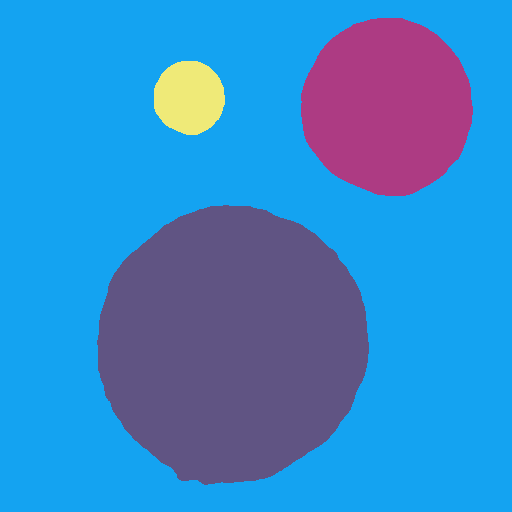

['a highly detailed photorealistic image of {a persimmon:7924463}, {an apricot:8606816} and {an orange:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of an apricot'}, 7924463: {'caption': 'a highly detailed photorealistic image of a persimmon'}}


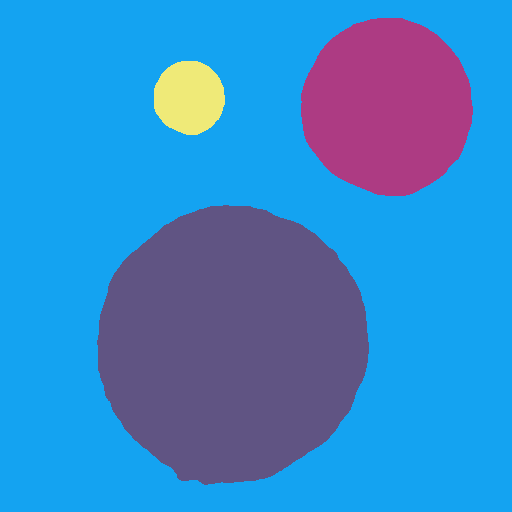

['a highly detailed photorealistic image of {a pumpkin:7924463}, {a persimmon:8606816} and {an orange:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of a persimmon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pumpkin'}}


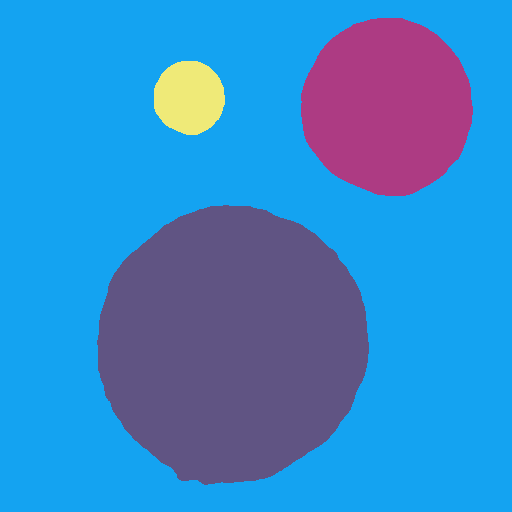

['a highly detailed photorealistic image of {an orange:7924463}, {a pumpkin:8606816} and {an apricot:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of an apricot'}, 8606816: {'caption': 'a highly detailed photorealistic image of a pumpkin'}, 7924463: {'caption': 'a highly detailed photorealistic image of an orange'}}


In [121]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    display_example(x)
    examples.append(x)

Path("evaldata").mkdir(exist_ok=True)
with open("evaldata/threeorange1.pkl", "wb") as f:
    pkl.dump(examples, f)
    


Unknown image resource 1092


a photo of <OBJ_E>
(512, 512, 3) 255


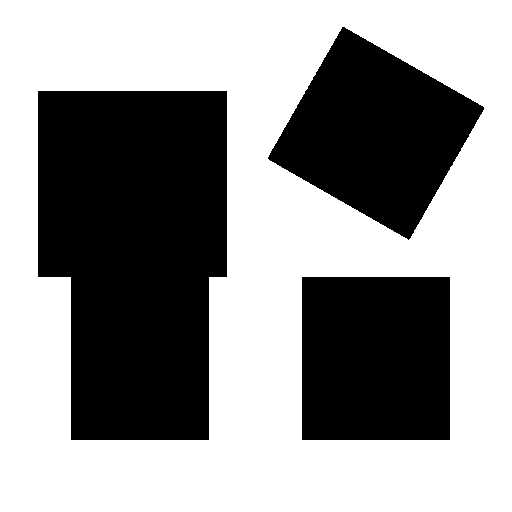

a photo of <OBJ_A>
(512, 512, 3) 255


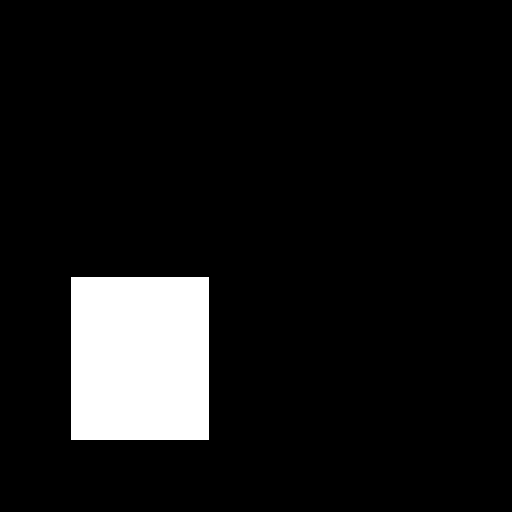

a photo of <OBJ_B>
(512, 512, 3) 255


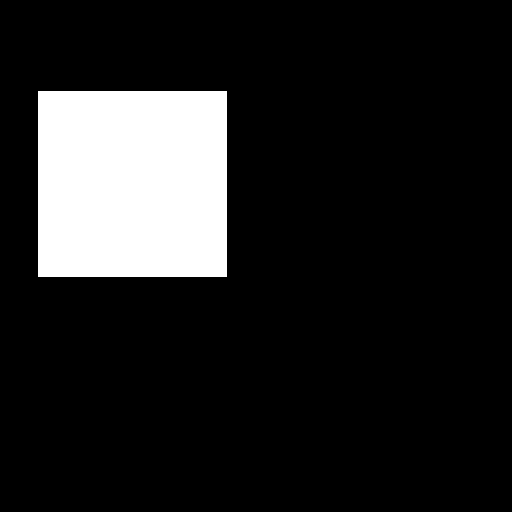

a photo of <OBJ_C>
(512, 512, 3) 255


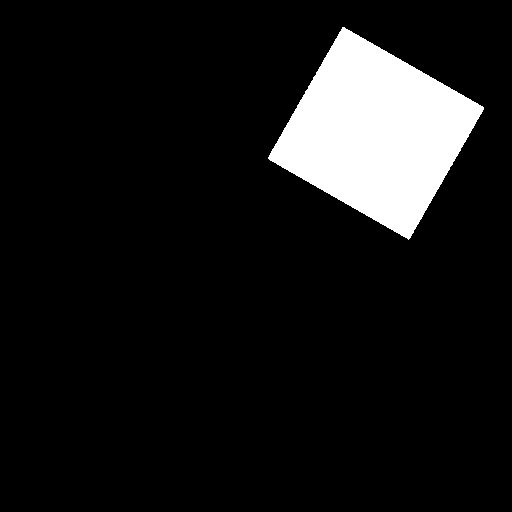

a photo of <OBJ_D>
(512, 512, 3) 255


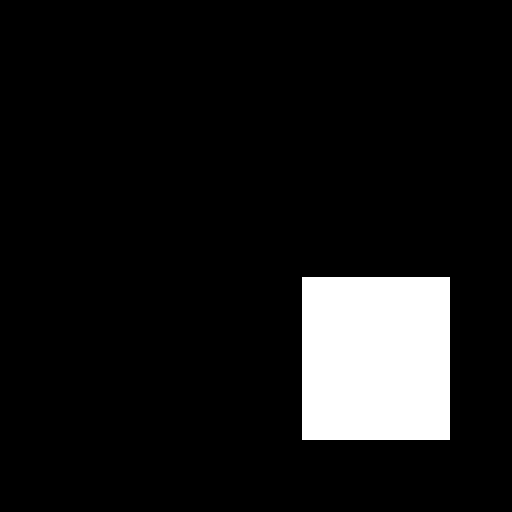

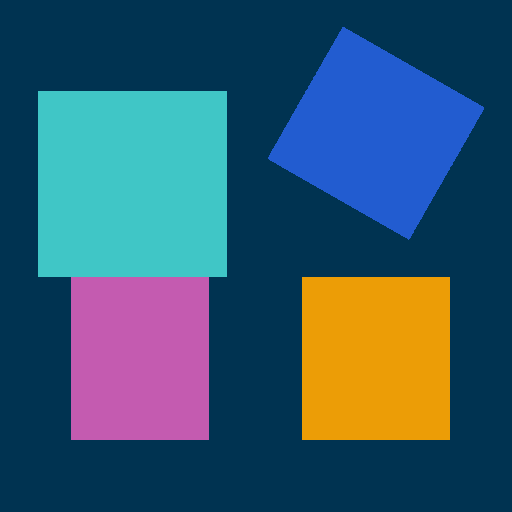

['a photo of {<OBJ_B>:11557828} on top of {<OBJ_A>:13026880}, and to the right {<OBJ_C>:13655074} falling on {<OBJ_D>:433644}. Background is {<OBJ_E>:5321472}.']
{5321472: {'caption': 'a photo of <OBJ_E>'}, 11557828: {'caption': 'a photo of <OBJ_A>'}, 13026880: {'caption': 'a photo of <OBJ_B>'}, 13655074: {'caption': 'a photo of <OBJ_C>'}, 433644: {'caption': 'a photo of <OBJ_D>'}}


In [52]:
fp = 'evaldata/foursquares.psd'

torch.manual_seed(48)
prototype = psd_to_cocopanoptic(fp)
display_example(prototype)

In [53]:
# setting three: four squares
objects = ["an old-school tv", "a cardboard box", "a square watermelon", "a concrete block", "spongebob", 
           "a yellow book", "a washing machine", "a gopro camera"]
backgrounds = ["a lush forest", "a brick wall", "a living room"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_E>": bgr}
    for objperm in itertools.permutations(objects, 4):
        for posname, obj in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>", "<OBJ_D>"], objperm):
            spec[posname] = obj
        specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:20]
retspecs += specs

for spec in specs:
    print(spec)
    
"""
# iterate through possible combinations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    specset = set()
    for objperm in itertools.combinations_with_replacement(objects, 3):
        # print(objperm)
        _spec = deepcopy(spec)
        for colorperm in itertools.combinations_with_replacement(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                _spec[posname] = obj.format(color=color)
            specset = set(_spec.values())
            if len(specset) < len(_spec):
                continue
            specs.append(deepcopy(_spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)

#"""

5040
{'<OBJ_E>': 'a living room', '<OBJ_A>': 'a concrete block', '<OBJ_B>': 'a yellow book', '<OBJ_C>': 'a gopro camera', '<OBJ_D>': 'spongebob'}
{'<OBJ_E>': 'a lush forest', '<OBJ_A>': 'spongebob', '<OBJ_B>': 'a gopro camera', '<OBJ_C>': 'a cardboard box', '<OBJ_D>': 'an old-school tv'}
{'<OBJ_E>': 'a brick wall', '<OBJ_A>': 'a square watermelon', '<OBJ_B>': 'a gopro camera', '<OBJ_C>': 'a concrete block', '<OBJ_D>': 'spongebob'}
{'<OBJ_E>': 'a lush forest', '<OBJ_A>': 'a washing machine', '<OBJ_B>': 'spongebob', '<OBJ_C>': 'a cardboard box', '<OBJ_D>': 'an old-school tv'}
{'<OBJ_E>': 'a brick wall', '<OBJ_A>': 'a washing machine', '<OBJ_B>': 'spongebob', '<OBJ_C>': 'a cardboard box', '<OBJ_D>': 'a square watermelon'}
{'<OBJ_E>': 'a brick wall', '<OBJ_A>': 'a concrete block', '<OBJ_B>': 'a square watermelon', '<OBJ_C>': 'a yellow book', '<OBJ_D>': 'a washing machine'}
{'<OBJ_E>': 'a lush forest', '<OBJ_A>': 'a gopro camera', '<OBJ_B>': 'a washing machine', '<OBJ_C>': 'a square waterme

'\n# iterate through possible combinations\nspecs = []\nfor bgr in backgrounds:\n    spec = {"<OBJ_D>": bgr}\n    specset = set()\n    for objperm in itertools.combinations_with_replacement(objects, 3):\n        # print(objperm)\n        _spec = deepcopy(spec)\n        for colorperm in itertools.combinations_with_replacement(object_colors, 3):\n            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):\n                _spec[posname] = obj.format(color=color)\n            specset = set(_spec.values())\n            if len(specset) < len(_spec):\n                continue\n            specs.append(deepcopy(_spec))\n            \nprint(len(specs))\nrandom.shuffle(specs)\nspecs = specs[:10]\nretspecs += specs\n\nfor spec in specs:\n    print(spec)\n\n#'

In [54]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    #display_example(x)
    examples.append(x)

Path("evaldata").mkdir(exist_ok=True)
with open("evaldata/foursquares1.pkl", "wb") as f:
    pkl.dump(examples, f)
    


a photo of <OBJ_D>
(512, 512, 3) 255


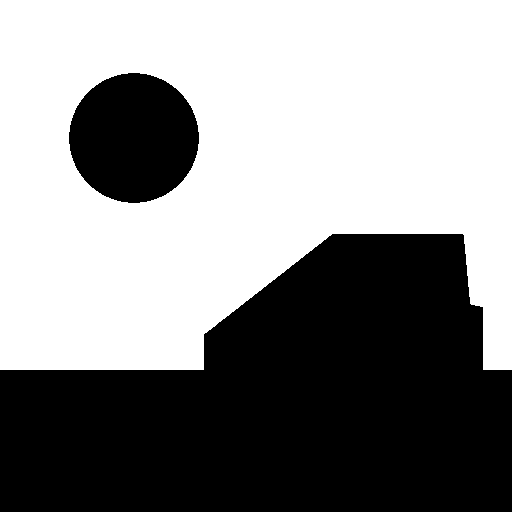

a photo of <OBJ_A>
(512, 512, 3) 255


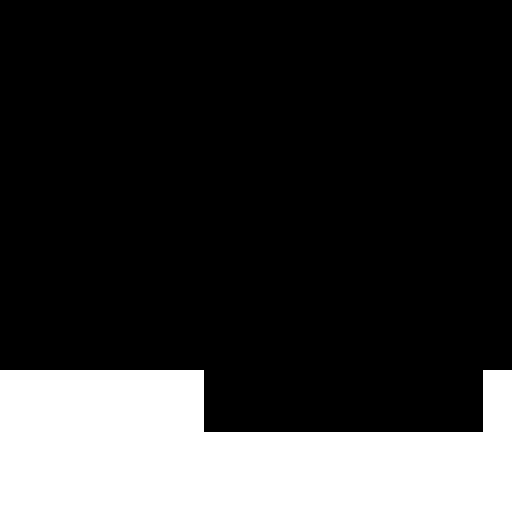

a photo of <OBJ_B>
(512, 512, 3) 255


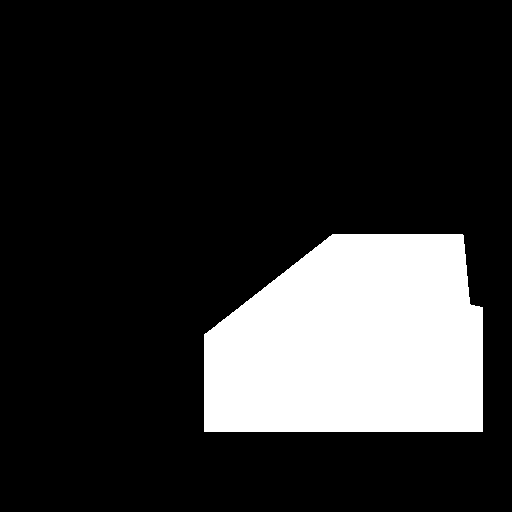

a photo of <OBJ_C>
(512, 512, 3) 255


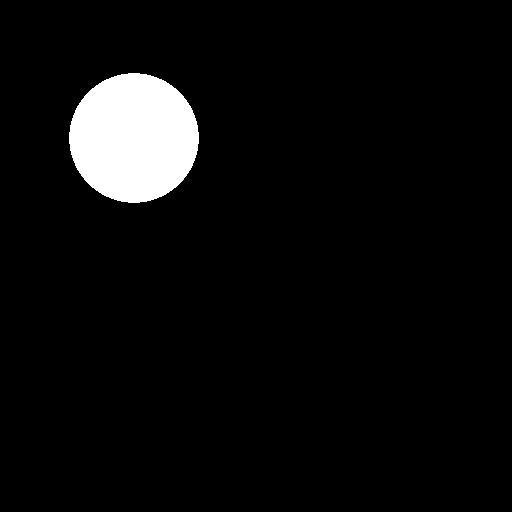

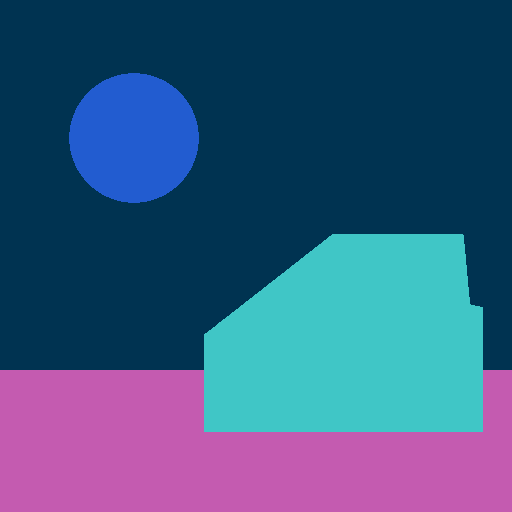

['a photo of {<OBJ_B>:13026880} {<OBJ_A>:11557828} Background is {<OBJ_D>:5321472} with {<OBJ_C>:13655074}.']
{5321472: {'caption': 'a photo of <OBJ_D>'}, 11557828: {'caption': 'a photo of <OBJ_A>'}, 13026880: {'caption': 'a photo of <OBJ_B>'}, 13655074: {'caption': 'a photo of <OBJ_C>'}}


In [47]:
fp = 'evaldata/openair.psd'

torch.manual_seed(48)
prototype = psd_to_cocopanoptic(fp)
display_example(prototype)

In [72]:
possibilities = {
    "<OBJ_A>": ["in the {desert}", "floating in the {sea}", "standing on the {ground}", "standing on {grass}"],
    "<OBJ_B>": ["a doll house", "a container ship", "an old shack", "a car"],
    ("<OBJ_D>", "<OBJ_C>"): [(["a dark starry night sky"], ["the moon", "a blood red moon", "a hot air balloon"]), (["a blue sky"], ["the sun", "the moon", "a hot air balloon", "the death star"]), (["a lush green forest"], ["a magical fire orb", "a red balloon"])]
}

def get_possibilities2(ps):
    ret = []
    if len(ps) == 0:
        return [{}]
    for k in ps.keys():
        vs = ps[k]
        del ps[k]
        downposs = get_possibilities(ps)
        for e in downposs:
            if isinstance(k, tuple):
                pass
            else:
                for ve in vs:
                    e_copy = deepcopy(e)
                    e_copy[k] = ve
                    ret.append(e_copy)
        break
    return ret

def get_possibilities(ps):
    ret = [{}]
    for k, vs in ps.items():
        newret = []
        for e in ret:
            for ve in vs:
                if isinstance(k, tuple):
                    assert isinstance(ve, tuple)
                    ves = itertools.product(*ve)
                    for vee in ves:
                        e_copy = deepcopy(e)
                        for ke, veee in zip(k, vee):
                            e_copy[ke] = veee
                        newret.append(e_copy)
                else:
                    e_copy = deepcopy(e)
                    e_copy[k] = ve
                    newret.append(e_copy)
        ret = newret
    return ret
    
pss = get_possibilities(possibilities)
print(len(pss))
    
specs = pss
random.shuffle(specs)
specs = specs[:20]
for psse in specs:
    print(psse)
    
    

144
{'<OBJ_A>': 'in the {desert}', '<OBJ_B>': 'a doll house', '<OBJ_D>': 'a blue sky', '<OBJ_C>': 'a hot air balloon'}
{'<OBJ_A>': 'standing on {grass}', '<OBJ_B>': 'a container ship', '<OBJ_D>': 'a blue sky', '<OBJ_C>': 'the death star'}
{'<OBJ_A>': 'in the {desert}', '<OBJ_B>': 'an old shack', '<OBJ_D>': 'a lush green forest', '<OBJ_C>': 'a magical fire orb'}
{'<OBJ_A>': 'standing on the {ground}', '<OBJ_B>': 'an old shack', '<OBJ_D>': 'a dark starry night sky', '<OBJ_C>': 'the moon'}
{'<OBJ_A>': 'floating in the {sea}', '<OBJ_B>': 'a container ship', '<OBJ_D>': 'a dark starry night sky', '<OBJ_C>': 'the moon'}
{'<OBJ_A>': 'standing on {grass}', '<OBJ_B>': 'a car', '<OBJ_D>': 'a dark starry night sky', '<OBJ_C>': 'the moon'}
{'<OBJ_A>': 'floating in the {sea}', '<OBJ_B>': 'a container ship', '<OBJ_D>': 'a blue sky', '<OBJ_C>': 'the death star'}
{'<OBJ_A>': 'in the {desert}', '<OBJ_B>': 'a container ship', '<OBJ_D>': 'a dark starry night sky', '<OBJ_C>': 'a hot air balloon'}
{'<OBJ_A>

In [74]:
examples = []
for spec in specs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)
    
Path("evaldata").mkdir(exist_ok=True)
with open("evaldata/openair1.pkl", "wb") as f:
    pkl.dump(examples, f)

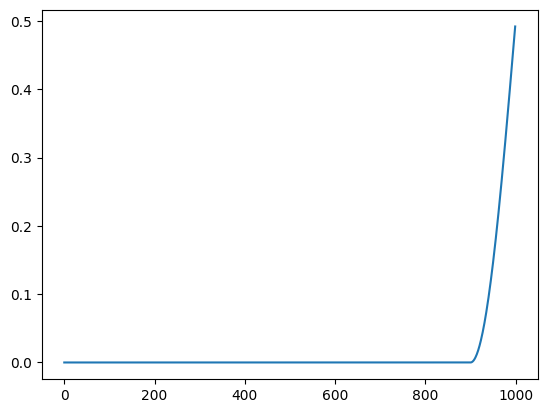

In [124]:
# check schedule equations
from matplotlib import pyplot as plt


def schedule(t, threshold=1000, softness=0.2, T=1000):  # t between 1000 and 0
    Ts = int(threshold + T * softness / 2)
    Te = int(threshold - T * softness / 2)
    if t >= Ts:
        return 1
    elif t <= Te:
        return 0
    else:
        return 1/2 + 1/2*np.sin(np.pi* (t-threshold)/(Ts - Te))
    
ts = [i for i in range(1000)]
plt.plot([schedule(t, threshold=1000) for t in ts])

<Axes: >

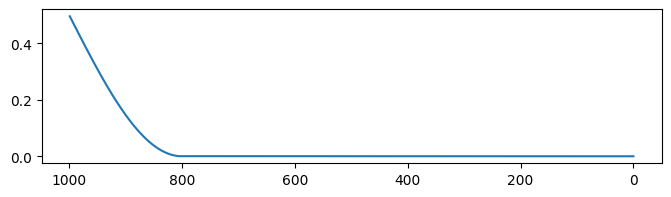

In [141]:
# !pip install seaborn
import seaborn as sns
plt.gca().invert_xaxis()
plt.rcParams['figure.figsize'] = (4,1)

def schedule(t, softness=0.4, T=1000):  # t between 1000 and 0
    Te = int(T * (1 - softness / 2))
    if t <= Te:
        return 0
    else:
        return 1/2 + 1/2*np.sin(np.pi* (t-T)/(softness * T))
    
ts = [i for i in range(1000)]
sns.lineplot(x=ts, y=[schedule(t) for t in ts])

<Axes: >

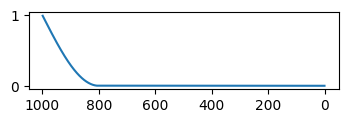

In [158]:
# !pip install seaborn
import seaborn as sns
plt.gca().invert_xaxis()
plt.rcParams['figure.figsize'] = (4,1)

def schedule(t, softness=0.4, T=1000):  # t between 1000 and 0
    Te = int(T * (1 - softness / 2))
    if t <= Te:
        return 0
    else:
        return 1+np.cos(np.pi * (t -T)/(softness * T) - np.pi/2)
    
ts = [i for i in range(1000)]
sns.lineplot(x=ts, y=[schedule(t) for t in ts])